In [1]:
import pandas as pd
import numpy as np
import random
import copy

In [2]:
seed = 42

In [3]:
data = pd.read_csv('../GeneralData/ETTh2.csv')
data

date       HUFL    HULL       MUFL    MULL    LUFL  \
0      2016-07-01 00:00:00  41.130001  12.481  36.535999   9.355   4.424   
1      2016-07-01 01:00:00  37.528000  10.136  33.936001   7.532   4.435   
2      2016-07-01 02:00:00  37.946999  11.309  35.330002   9.007   2.100   
3      2016-07-01 03:00:00  38.952000  11.895  35.543999   9.436   3.380   
4      2016-07-01 04:00:00  38.113998  11.476  35.410000   9.623   2.036   
...                    ...        ...     ...        ...     ...     ...   
17415  2018-06-26 15:00:00  39.202999  11.392  49.644001  11.929 -10.331   
17416  2018-06-26 16:00:00  38.113998  10.974  48.759998  11.366 -10.331   
17417  2018-06-26 17:00:00  39.622002  10.974  50.609001  11.661 -11.557   
17418  2018-06-26 18:00:00  43.643002  13.403  54.737000  13.778 -10.299   
17419  2018-06-26 19:00:00  38.868000  10.052  49.859001  10.669 -11.525   

        LULL         OT  
0      1.311  38.661999  
1      1.215  37.124001  
2      0.000  36.465000  
3      1.215  33.608501  
4      0.000  31.850500  
...      ...        ...  
17415 -1.258  47.084999  
17416 -1.290  48.183498  
17417 -1.418  48.183498  
17418 -1.418  46.865501  
17419 -1.418  45.986500  

[17420 rows x 8 columns]

In [4]:
import torch.nn as nn

/home/sjlee/sj_virtual/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
feature_size = 7

In [6]:
# LSTM은 Encoder와 Decoder를 각각 구현해야 한다.
class LSTM(nn.Module):
    def __init__(self):
        super().__init__()
        self.hidden_size = 14
        self.input_size = feature_size
        self.encoder = nn.LSTM(input_size = self.input_size,
                       hidden_size = self.hidden_size,
                       num_layers = 1,
                       batch_first = True).to(device)
        # batch_first = True로 인해서 (batch,seq,feature)순으로 입력 받는다.
        # 그 당시에 알고 있는 정보가 없으므로 input_size = 0
        self.decoder = nn.LSTM(input_size = self.input_size,
                       hidden_size = self.hidden_size,
                       num_layers = 1,
                       batch_first = True).to(device)
        
        
        self.output_layer = nn.Linear(self.hidden_size, 1).to(device)
    def forward(self,x):
        x = x.to(device)
        self.encoder.flatten_parameters()
        self.decoder.flatten_parameters()
        outputs,(hidden,cell) = self.encoder(x)
        
        # 현재 prediction_length = 1이기 때문에, 반복문을 돌리지 않아도 됨
        # but 길어진다면 반복문을 돌려서 output값을 얻어야 한다.
        # 기본적으로 output = hidden state이기에 output을 생성할
        # Fully Connected Layer가 필요하게 된다.
        # 이때 decoder_output의 사이즈는 (batch,seq,hidden) 이다
        # 중간에 seq가 들어오게 되는 이유는 입력 크기 만큼 lstm이 반복되기 때문에
        # seq=1 이기 때문에 squeeze를 수행
        
        hidden = hidden.to(device)
        cell = cell.to(device)
        decoder_input = torch.zeros([x.size(0),1,x.size(2)]).to(device)
        decoder_out,(hidden,cell) = self.decoder(decoder_input,(hidden,cell))
        decoder_out = decoder_out.squeeze(1)
        
        out = self.output_layer(decoder_out)
        
        return out

In [7]:
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader
import torch

In [8]:
device = torch.device("cuda:0")

In [9]:
sequence_length = 24 # 1일
pred_length = 1 # 1시간
split = int(len(data)*0.8)

In [10]:
def seq_data(x,sequence_length,pred_len):
    seq_list = []
    target_list = []
    device = torch.device("cuda:0")
    for i in range(0,len(x)-sequence_length):
        # 시간데이터를 제외하고 추출
        seq_list.append(x.iloc[i:i+sequence_length,1:].values)
        # OT만 추출
        target_list.append(x.iloc[i+sequence_length,-1])
        
    return torch.FloatTensor(seq_list).view(-1,sequence_length,7).to(device), torch.FloatTensor(target_list).view(-1,pred_len,1).to(device)

In [11]:
train = data.iloc[:split]
val = data.iloc[split:]

X_train, y_train = seq_data(train,sequence_length,pred_length)
X_val, y_val = seq_data(val,sequence_length,pred_length)

tr_dataset = TensorDataset(X_train, y_train)
val_dataset = TensorDataset(X_val,y_val)

training =  DataLoader(tr_dataset,batch_size = 64)
validation = DataLoader(val_dataset,batch_size = 64)

/tmp/ipykernel_1131044/2507691695.py:11: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:230.)
  return torch.FloatTensor(seq_list).view(-1,sequence_length,7).to(device), torch.FloatTensor(target_list).view(-1,pred_len,1).to(device)


In [12]:
torch.cuda.is_available()

True

In [13]:
X_train.size() # 168개의 sequence_length 7개의 Feature

torch.Size([13912, 24, 7])

* 잘 데이터가 구성된 걸 확인 가능

In [14]:
train.iloc[:169]

date       HUFL    HULL       MUFL    MULL   LUFL   LULL  \
0    2016-07-01 00:00:00  41.130001  12.481  36.535999   9.355  4.424  1.311   
1    2016-07-01 01:00:00  37.528000  10.136  33.936001   7.532  4.435  1.215   
2    2016-07-01 02:00:00  37.946999  11.309  35.330002   9.007  2.100  0.000   
3    2016-07-01 03:00:00  38.952000  11.895  35.543999   9.436  3.380  1.215   
4    2016-07-01 04:00:00  38.113998  11.476  35.410000   9.623  2.036  0.000   
..                   ...        ...     ...        ...     ...    ...    ...   
164  2016-07-07 20:00:00  46.155998  12.900  42.112000  10.079  3.497  0.000   
165  2016-07-07 21:00:00  50.008999  14.659  45.865002  11.205  3.753  1.237   
166  2016-07-07 22:00:00  46.826000  14.743  44.417000  12.223  2.580  0.000   
167  2016-07-07 23:00:00  45.235001  13.905  43.022999  11.714  2.665  0.000   
168  2016-07-08 00:00:00  44.731998  13.905  42.433998  11.741  1.311  0.000   

            OT  
0    38.661999  
1    37.124001  
2    36.465000  
3    33.608501  
4    31.850500  
..         ...  
164  41.299000  
165  40.200500  
166  39.321499  
167  38.881500  
168  38.223000  

[169 rows x 8 columns]

In [15]:
X_train

tensor([[[41.1300, 12.4810, 36.5360,  ...,  4.4240,  1.3110, 38.6620],
         [37.5280, 10.1360, 33.9360,  ...,  4.4350,  1.2150, 37.1240],
         [37.9470, 11.3090, 35.3300,  ...,  2.1000,  0.0000, 36.4650],
         ...,
         [36.5230, 10.4710, 33.5070,  ...,  2.7080,  0.0000, 25.6985],
         [36.1040, 10.3870, 34.1240,  ...,  2.7080,  0.0000, 25.9180],
         [36.4390, 10.6390, 33.4800,  ...,  2.7080,  0.0000, 25.9180]],

        [[37.5280, 10.1360, 33.9360,  ...,  4.4350,  1.2150, 37.1240],
         [37.9470, 11.3090, 35.3300,  ...,  2.1000,  0.0000, 36.4650],
         [38.9520, 11.8950, 35.5440,  ...,  3.3800,  1.2150, 33.6085],
         ...,
         [36.1040, 10.3870, 34.1240,  ...,  2.7080,  0.0000, 25.9180],
         [36.4390, 10.6390, 33.4800,  ...,  2.7080,  0.0000, 25.9180],
         [35.6010, 11.4760, 33.6950,  ...,  1.5350,  0.0000, 25.9180]],

        [[37.9470, 11.3090, 35.3300,  ...,  2.1000,  0.0000, 36.4650],
         [38.9520, 11.8950, 35.5440,  ...,  3

In [16]:
y_train

tensor([[[25.9180]],

        [[26.3575]],

        [[26.1375]],

        ...,

        [[15.5910]],

        [[15.8105]],

        [[15.1515]]], device='cuda:0')

In [17]:
from torch.optim import Adam

In [18]:
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed) # 난수 선언(원래는 cnt선언 위에 있었다)
model = LSTM().to(device)
optimizer = Adam(model.parameters(),lr = 1e-4)
num_epochs = 200
n = len(training)

In [19]:
def MSE(pred,target):
    return torch.mean((pred-target)**2,dim = 0) # reduction까지 취해줌

In [20]:
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
minimal_loss=np.inf
for epoch in range(num_epochs):  # loop over the dataset multiple times
    running_loss = 0.0
    for inputs, labels in training:
        # forward pass
        inputs = inputs
        outputs = model(inputs)
#         print(outputs.size())
        outputs = outputs.view(-1,1)    
        labels = labels.view(-1,1)
        
        # defining loss
        loss = MSE(outputs, labels)
        # zero the parameter gradients
        optimizer.zero_grad()
        # computing gradients
        loss.backward()
        # accumulating running loss
        running_loss += loss.item()
        # updated weights based on computed gradients
        optimizer.step()
    print('Epoch [%d]/[%d] running accumulative loss across all batches: %.3f' %(epoch + 1, num_epochs, (running_loss/n)))
    if (running_loss/n)*100<minimal_loss:
        best_model = copy.deepcopy(model)
        minimal_loss = (running_loss/n)*100
        print("changed")

model = best_model

Epoch [1]/[200] running accumulative loss across all batches: 871.561
changed
Epoch [2]/[200] running accumulative loss across all batches: 862.202
changed
Epoch [3]/[200] running accumulative loss across all batches: 849.319
changed
Epoch [4]/[200] running accumulative loss across all batches: 831.092
changed
Epoch [5]/[200] running accumulative loss across all batches: 809.351
changed
Epoch [6]/[200] running accumulative loss across all batches: 785.548
changed
Epoch [7]/[200] running accumulative loss across all batches: 761.504
changed
Epoch [8]/[200] running accumulative loss across all batches: 740.473
changed
Epoch [9]/[200] running accumulative loss across all batches: 719.297
changed
Epoch [10]/[200] running accumulative loss across all batches: 701.700
changed
Epoch [11]/[200] running accumulative loss across all batches: 684.800
changed
Epoch [12]/[200] running accumulative loss across all batches: 668.136
changed
Epoch [13]/[200] running accumulative loss across all batches

Epoch [105]/[200] running accumulative loss across all batches: 88.479
changed
Epoch [106]/[200] running accumulative loss across all batches: 86.381
changed
Epoch [107]/[200] running accumulative loss across all batches: 84.328
changed
Epoch [108]/[200] running accumulative loss across all batches: 82.315
changed
Epoch [109]/[200] running accumulative loss across all batches: 80.334
changed
Epoch [110]/[200] running accumulative loss across all batches: 78.417
changed
Epoch [111]/[200] running accumulative loss across all batches: 76.535
changed
Epoch [112]/[200] running accumulative loss across all batches: 74.689
changed
Epoch [113]/[200] running accumulative loss across all batches: 72.889
changed
Epoch [114]/[200] running accumulative loss across all batches: 71.136
changed
Epoch [115]/[200] running accumulative loss across all batches: 69.417
changed
Epoch [116]/[200] running accumulative loss across all batches: 67.751
changed
Epoch [117]/[200] running accumulative loss across a

In [21]:
from captum.attr import IntegratedGradients,NoiseTunnel

In [22]:
for val in validation:
    print(val[0].size())

torch.Size([64, 24, 7])
torch.Size([64, 24, 7])
torch.Size([64, 24, 7])
torch.Size([64, 24, 7])
torch.Size([64, 24, 7])
torch.Size([64, 24, 7])
torch.Size([64, 24, 7])
torch.Size([64, 24, 7])
torch.Size([64, 24, 7])
torch.Size([64, 24, 7])
torch.Size([64, 24, 7])
torch.Size([64, 24, 7])
torch.Size([64, 24, 7])
torch.Size([64, 24, 7])
torch.Size([64, 24, 7])
torch.Size([64, 24, 7])
torch.Size([64, 24, 7])
torch.Size([64, 24, 7])
torch.Size([64, 24, 7])
torch.Size([64, 24, 7])
torch.Size([64, 24, 7])
torch.Size([64, 24, 7])
torch.Size([64, 24, 7])
torch.Size([64, 24, 7])
torch.Size([64, 24, 7])
torch.Size([64, 24, 7])
torch.Size([64, 24, 7])
torch.Size([64, 24, 7])
torch.Size([64, 24, 7])
torch.Size([64, 24, 7])
torch.Size([64, 24, 7])
torch.Size([64, 24, 7])
torch.Size([64, 24, 7])
torch.Size([64, 24, 7])
torch.Size([64, 24, 7])
torch.Size([64, 24, 7])
torch.Size([64, 24, 7])
torch.Size([64, 24, 7])
torch.Size([64, 24, 7])
torch.Size([64, 24, 7])
torch.Size([64, 24, 7])
torch.Size([64, 

In [23]:
test = next(iter(validation))[0][0] # 하나의 sample에 대해서 진행
test = test.unsqueeze(0)
test.size()

torch.Size([1, 24, 7])

In [24]:
ig = IntegratedGradients(model)
nt_ig = NoiseTunnel(ig)
attr_score = nt_ig.attribute(test)
attr_score

tensor([[[-6.4124e-03, -8.2049e-04, -7.3626e-03, -5.4643e-04, -1.3739e-04,
           1.2862e-05, -9.7849e-04],
         [-7.6592e-03, -1.5305e-04, -7.0781e-03, -2.0172e-04,  1.8469e-04,
           7.5058e-05, -2.7820e-03],
         [-7.8100e-03, -4.2037e-05, -6.5140e-03, -2.3029e-04,  1.7457e-05,
           5.1597e-05, -3.1903e-03],
         [-1.0311e-02, -1.5482e-05, -8.8134e-03, -8.0955e-05,  1.4975e-04,
           9.5731e-05, -1.6732e-03],
         [-1.1776e-02,  2.4828e-05, -1.0497e-02,  1.2432e-04,  8.4238e-05,
          -4.0303e-05, -2.2329e-03],
         [-1.6930e-02, -6.7921e-04, -9.0034e-03, -9.9296e-05,  5.3765e-05,
          -7.8350e-05, -2.0932e-03],
         [-1.8453e-02, -5.8340e-04, -8.9477e-03,  1.0601e-04,  2.0419e-04,
           4.0846e-05, -2.2209e-03],
         [-1.6370e-02,  1.2806e-05, -9.8777e-03, -7.8185e-05,  3.4616e-04,
           2.8360e-04, -2.1731e-03],
         [-1.8075e-02, -2.1393e-05, -1.2270e-02,  4.5024e-04,  1.2742e-04,
           2.7460e-04, -6.927

In [25]:
attr_score.size()

torch.Size([1, 24, 7])

In [26]:
attr_score.to("cpu")

tensor([[[-6.4124e-03, -8.2049e-04, -7.3626e-03, -5.4643e-04, -1.3739e-04,
           1.2862e-05, -9.7849e-04],
         [-7.6592e-03, -1.5305e-04, -7.0781e-03, -2.0172e-04,  1.8469e-04,
           7.5058e-05, -2.7820e-03],
         [-7.8100e-03, -4.2037e-05, -6.5140e-03, -2.3029e-04,  1.7457e-05,
           5.1597e-05, -3.1903e-03],
         [-1.0311e-02, -1.5482e-05, -8.8134e-03, -8.0955e-05,  1.4975e-04,
           9.5731e-05, -1.6732e-03],
         [-1.1776e-02,  2.4828e-05, -1.0497e-02,  1.2432e-04,  8.4238e-05,
          -4.0303e-05, -2.2329e-03],
         [-1.6930e-02, -6.7921e-04, -9.0034e-03, -9.9296e-05,  5.3765e-05,
          -7.8350e-05, -2.0932e-03],
         [-1.8453e-02, -5.8340e-04, -8.9477e-03,  1.0601e-04,  2.0419e-04,
           4.0846e-05, -2.2209e-03],
         [-1.6370e-02,  1.2806e-05, -9.8777e-03, -7.8185e-05,  3.4616e-04,
           2.8360e-04, -2.1731e-03],
         [-1.8075e-02, -2.1393e-05, -1.2270e-02,  4.5024e-04,  1.2742e-04,
           2.7460e-04, -6.927

In [27]:
plot_attribution = attr_score.to("cpu").detach().numpy()
plot_attribution

array([[[-6.41235181e-03, -8.20491417e-04, -7.36261373e-03,
         -5.46429655e-04, -1.37388708e-04,  1.28622396e-05,
         -9.78489803e-04],
        [-7.65917549e-03, -1.53047187e-04, -7.07808511e-03,
         -2.01715684e-04,  1.84687531e-04,  7.50581341e-05,
         -2.78201316e-03],
        [-7.80996362e-03, -4.20373180e-05, -6.51395679e-03,
         -2.30289855e-04,  1.74568578e-05,  5.15967247e-05,
         -3.19031450e-03],
        [-1.03113437e-02, -1.54816976e-05, -8.81336328e-03,
         -8.09546442e-05,  1.49747879e-04,  9.57308235e-05,
         -1.67320132e-03],
        [-1.17762018e-02,  2.48283522e-05, -1.04973352e-02,
          1.24322655e-04,  8.42378996e-05, -4.03031757e-05,
         -2.23293267e-03],
        [-1.69300777e-02, -6.79208727e-04, -9.00336173e-03,
         -9.92957587e-05,  5.37653390e-05, -7.83503814e-05,
         -2.09318272e-03],
        [-1.84529840e-02, -5.83395669e-04, -8.94766506e-03,
          1.06011639e-04,  2.04187053e-04,  4.08463160e-05

In [28]:
plot_attribution = plot_attribution.reshape(-1,7)

In [29]:
column = data.columns[1:]
column

Index(['HUFL', 'HULL', 'MUFL', 'MULL', 'LUFL', 'LULL', 'OT'], dtype='object')

In [30]:
attr_df = pd.DataFrame(plot_attribution,columns=column)

In [31]:
attr_df

HUFL      HULL      MUFL      MULL      LUFL      LULL         OT
0  -0.006412 -0.000820 -0.007363 -0.000546 -0.000137  0.000013  -0.000978
1  -0.007659 -0.000153 -0.007078 -0.000202  0.000185  0.000075  -0.002782
2  -0.007810 -0.000042 -0.006514 -0.000230  0.000017  0.000052  -0.003190
3  -0.010311 -0.000015 -0.008813 -0.000081  0.000150  0.000096  -0.001673
4  -0.011776  0.000025 -0.010497  0.000124  0.000084 -0.000040  -0.002233
5  -0.016930 -0.000679 -0.009003 -0.000099  0.000054 -0.000078  -0.002093
6  -0.018453 -0.000583 -0.008948  0.000106  0.000204  0.000041  -0.002221
7  -0.016370  0.000013 -0.009878 -0.000078  0.000346  0.000284  -0.002173
8  -0.018075 -0.000021 -0.012270  0.000450  0.000127  0.000275  -0.000693
9  -0.016745 -0.000053 -0.016340  0.000669  0.000184 -0.000087  -0.000030
10 -0.021915  0.000068 -0.014123  0.001739 -0.000070 -0.000086   0.001721
11 -0.031619  0.000267 -0.004865  0.002663  0.000010  0.000174   0.000075
12 -0.025146 -0.000597 -0.010437  0.001021  0.000300  0.000248   0.002172
13 -0.028953  0.000248 -0.006382  0.003891 -0.000430  0.000124   0.004910
14 -0.033661  0.000186  0.013023  0.000614  0.001010 -0.000477   0.000480
15 -0.040150  0.000341  0.032882  0.003766 -0.000126 -0.000309   0.002439
16 -0.035004 -0.001105  0.051069 -0.001655  0.000496 -0.000469   0.004379
17 -0.101438 -0.009758  0.142248  0.016413 -0.002428  0.000384   0.000111
18 -0.066078  0.000616  0.164555  0.014949 -0.005504  0.001052  -0.005647
19 -0.027538 -0.005360  0.213789  0.018895  0.004333 -0.000089   0.150786
20 -0.103635  0.000303  0.235307  0.010318  0.052712 -0.001316   0.463044
21  0.462961 -0.005250  0.877943 -0.063477  0.042710  0.006193  -2.576147
22  4.598334 -0.666403  0.290687 -0.645939 -0.248492 -0.017420  -7.590436
23 -4.814529  0.470292 -0.270947  0.493834  0.150033 -0.237807  26.483033

# 특징 관찰

### our goal -> 특정 시간대를 추출해내는 방법을 고안

In [32]:
next(iter(validation))[1][0]

tensor([[14.9320]], device='cuda:0')

* 전체 Attribution DataFrame이 예측값을 나눈것으로 보임
    * 현재 하나의 Sample Batch의 첫번째 Sample에 대해서 Attribution을 구했는데
    하나의 DataFrame이 나왔음

In [33]:
attr_df.sum(axis=0).sum()

17.527246527890153

## 전체 피쳐의 평균 영향
* 각 피쳐가 미치는 영향도를 구할 수 있음

<AxesSubplot: >

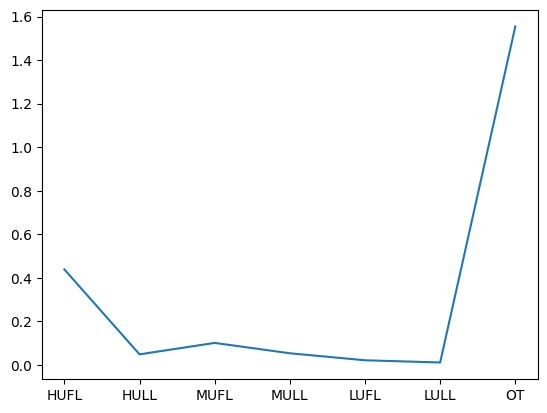

In [34]:
attr_df.abs().mean(axis=0).plot()

## 각 시간 별 영향 추이
* 각 시간별로 중요한 정도를 계산할 수 있음

<AxesSubplot: >

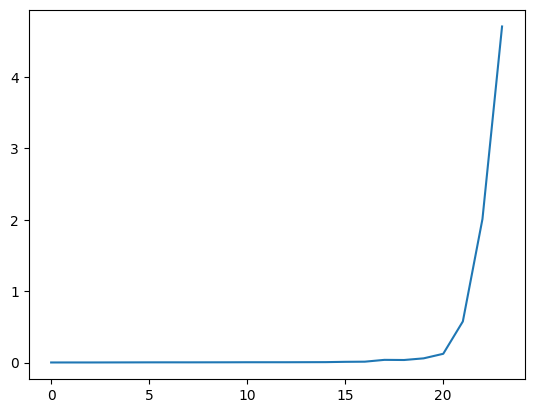

In [35]:
attr_df.abs().mean(axis = 1).plot()

## 각 피쳐별로 시간에 따른 영향 추이

<AxesSubplot: >

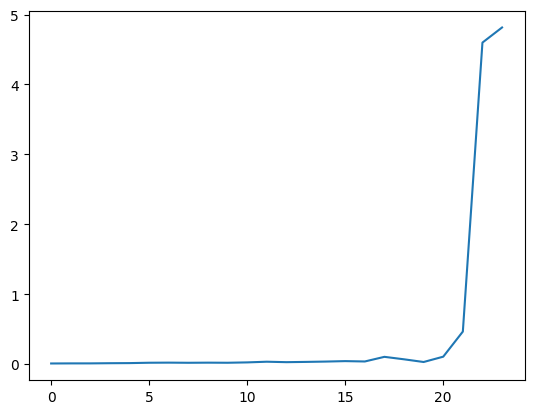

In [36]:
attr_df['HUFL'].abs().plot()

<AxesSubplot: >

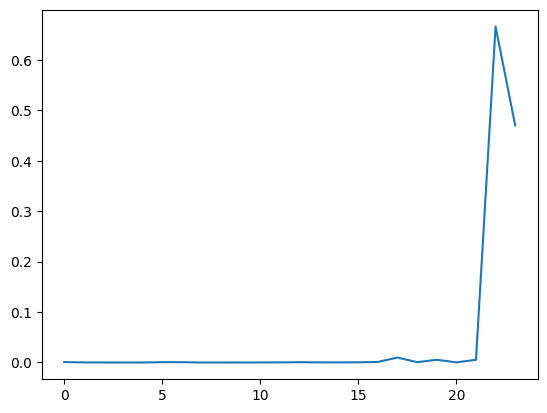

In [37]:
attr_df['HULL'].abs().plot()

<AxesSubplot: >

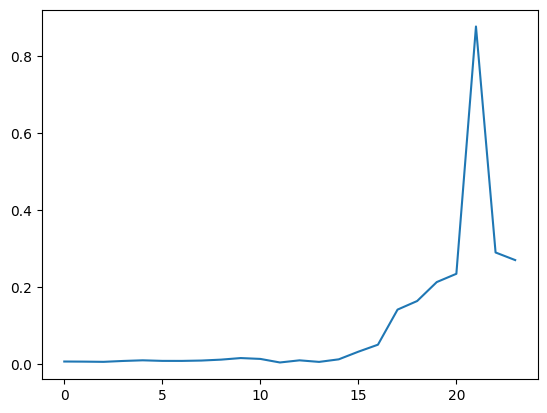

In [38]:
attr_df['MUFL'].abs().plot()

<AxesSubplot: >

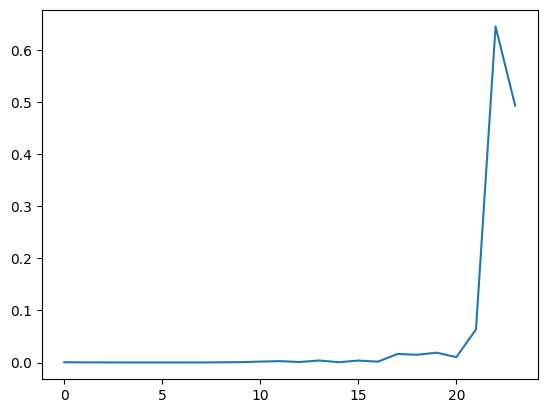

In [39]:
attr_df['MULL'].abs().plot()

<AxesSubplot: >

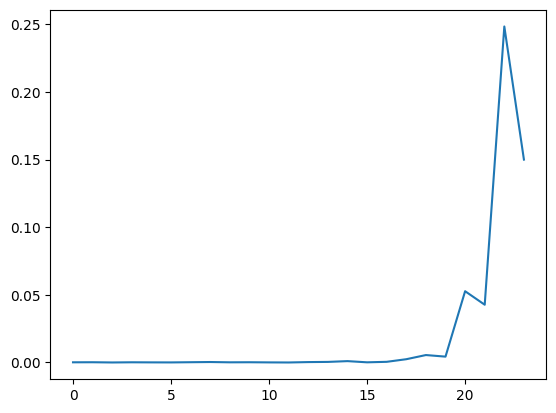

In [40]:
attr_df['LUFL'].abs().plot()

<AxesSubplot: >

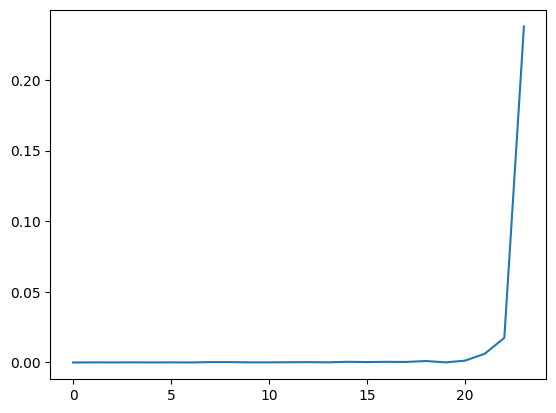

In [41]:
attr_df['LULL'].abs().plot()

<AxesSubplot: >

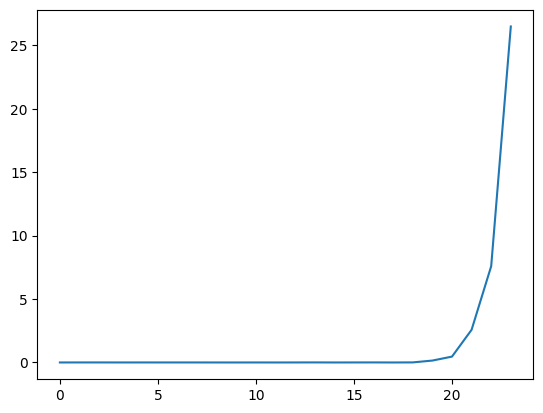

In [42]:
attr_df['OT'].abs().plot()

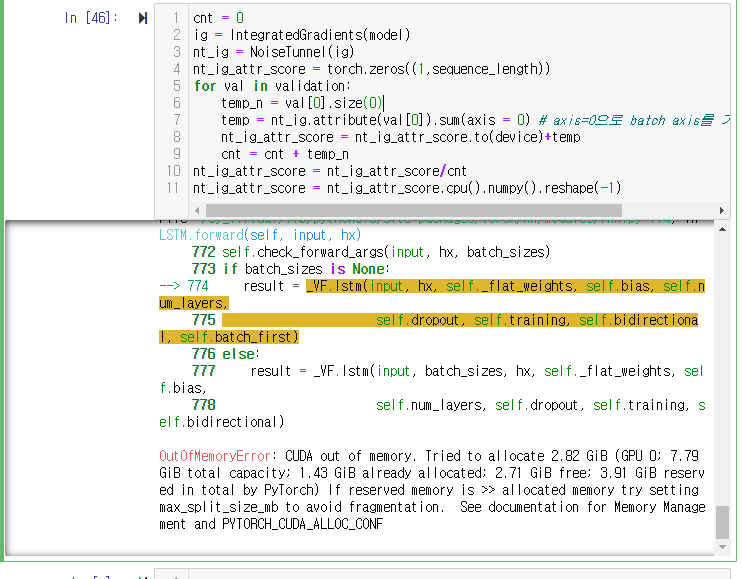

In [43]:
sequence_length

24

In [44]:
cnt = 0
ig = IntegratedGradients(model)
nt_ig = NoiseTunnel(ig)
nt_ig_attr_score = np.zeros((1,sequence_length))
for val_batch in validation:
    temp_n = val_batch[0].size(0)
    for val in val_batch[0]: # 하나의 배치에 대해서 for문
        val = val.unsqueeze(0)
        temp = nt_ig.attribute(val).abs()
        # 각 attribution score의 절대값을 합한다.
        # 이로써 각 시간별로 영향도를 구함
        # 이 부분이 abs를 씌우는게 절대적인 영향을 반영하는데에 맞는 것 같다.
        # 이전까진 씌우지 않았음
        temp = temp.to("cpu").detach().numpy().reshape(-1,feature_size)
        temp = temp.sum(axis=1) 
        nt_ig_attr_score = nt_ig_attr_score+temp
    cnt = cnt + temp_n
nt_ig_attr_score = nt_ig_attr_score/cnt

In [45]:
nt_ig_attr_score.reshape(-1)

array([ 0.10644913,  0.1278934 ,  0.10175122,  0.10852657,  0.1225562 ,
        0.1359151 ,  0.14853371,  0.16145188,  0.17473752,  0.18862055,
        0.20402186,  0.22093431,  0.24032975,  0.26299219,  0.29170199,
        0.32460357,  0.36516511,  0.4138558 ,  0.50077569,  0.69735925,
        1.30992788,  3.01645581,  9.99994461, 42.57967988])

<AxesSubplot: >

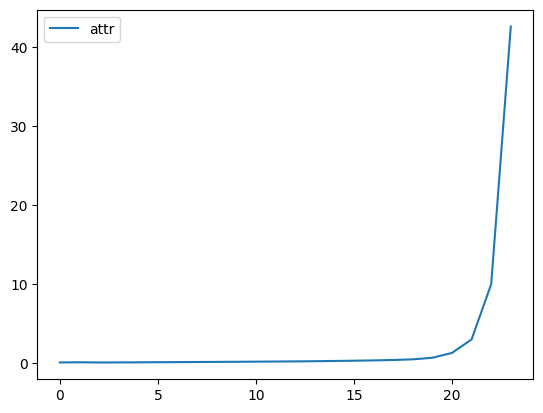

In [46]:
total_mean_attr_df = pd.DataFrame({"attr":nt_ig_attr_score.reshape(-1)})
total_mean_attr_df.plot()

In [47]:
for val_batch in validation:
    print(val_batch[0])
    for val in val_batch[0]:
        print(val)

tensor([[[ 4.5235e+01,  4.1880e+00,  4.9269e+01,  ..., -3.9870e+00,
          -1.3430e+00,  1.4273e+01],
         [ 4.3727e+01,  0.0000e+00,  4.7580e+01,  ..., -3.8490e+00,
          -1.2790e+00,  1.2954e+01],
         [ 4.3308e+01,  0.0000e+00,  4.6562e+01,  ..., -2.4730e+00,
          -1.2150e+00,  1.1196e+01],
         ...,
         [ 5.0093e+01,  6.1150e+00,  5.3049e+01,  ..., -2.8890e+00,
           0.0000e+00,  1.5371e+01],
         [ 4.9926e+01,  6.5340e+00,  5.3183e+01,  ..., -2.9210e+00,
           0.0000e+00,  1.4492e+01],
         [ 4.6072e+01,  5.3610e+00,  5.0556e+01,  ..., -4.0410e+00,
          -1.2260e+00,  1.5591e+01]],

        [[ 4.3727e+01,  0.0000e+00,  4.7580e+01,  ..., -3.8490e+00,
          -1.2790e+00,  1.2954e+01],
         [ 4.3308e+01,  0.0000e+00,  4.6562e+01,  ..., -2.4730e+00,
          -1.2150e+00,  1.1196e+01],
         [ 4.7245e+01,  0.0000e+00,  5.1065e+01,  ..., -3.7100e+00,
          -1.3110e+00,  9.2185e+00],
         ...,
         [ 4.9926e+01,  6

tensor([[ 4.3141e+01,  0.0000e+00,  4.4551e+01,  1.7690e+00, -1.3860e+00,
          0.0000e+00,  2.8470e+00],
        [ 4.1968e+01,  0.0000e+00,  4.3961e+01,  2.2520e+00, -2.6230e+00,
          0.0000e+00,  1.9680e+00],
        [ 4.0292e+01,  0.0000e+00,  4.3291e+01,  2.4130e+00, -2.6230e+00,
         -1.2580e+00,  1.3085e+00],
        [ 4.1298e+01,  0.0000e+00,  4.3801e+01,  2.0910e+00, -2.6230e+00,
          0.0000e+00,  4.2950e-01],
        [ 3.8701e+01,  0.0000e+00,  4.0503e+01,  1.4210e+00, -1.4390e+00,
          0.0000e+00, -9.5000e-03],
        [ 3.9790e+01,  0.0000e+00,  4.1603e+01,  0.0000e+00, -2.5480e+00,
          0.0000e+00, -4.4950e-01],
        [ 4.1549e+01,  0.0000e+00,  4.3747e+01,  1.4210e+00, -1.2790e+00,
          0.0000e+00, -8.8850e-01],
        [ 3.8617e+01,  0.0000e+00,  4.1281e+01,  0.0000e+00, -1.5570e+00,
          0.0000e+00, -1.1085e+00],
        [ 4.1884e+01,  0.0000e+00,  4.6347e+01,  1.7960e+00, -4.1050e+00,
          0.0000e+00,  1.0890e+00],
        [ 

tensor([[26.5540,  0.0000, 29.7280, -2.4390, -2.9110,  0.0000,  9.4385],
        [23.8740,  0.0000, 27.4220, -3.3510, -3.0490, -1.2260, 12.5145],
        [24.2930,  0.0000, 27.7710, -2.6000, -3.0490, -1.2370, 13.8330],
        [23.2040,  0.0000, 26.1090, -3.5120, -3.0490,  0.0000, 16.0305],
        [23.0360,  0.0000, 26.5380, -3.1090, -2.5800,  0.0000, 16.2500],
        [24.2090,  0.0000, 26.9670, -3.2170, -2.6330,  0.0000, 15.3710],
        [27.1410,  0.0000, 29.4060, -2.8410, -1.2150,  0.0000, 13.3935],
        [29.1510,  0.0000, 32.0330, -1.8500, -2.7290, -1.2150, 11.1965],
        [32.5860,  0.0000, 34.0160, -1.6350,  0.0000,  0.0000,  9.4385],
        [35.8530,  0.0000, 37.5280, -1.9840,  0.0000,  0.0000,  7.9000],
        [40.1250,  0.0000, 41.1200,  0.0000,  0.0000,  0.0000,  6.8015],
        [35.7690,  0.0000, 36.7770,  0.0000,  0.0000,  0.0000,  6.3625],
        [34.5120,  0.0000, 35.1690, -1.4740,  0.0000,  0.0000,  5.7035],
        [30.2400,  0.0000, 31.6040, -1.6350, -1.290

tensor([[ 12.3140,  -7.4550,  24.1250,  -5.0660, -11.7910,  -2.7080,  16.2500],
        [ 14.2410,  -6.0310,  25.3050,  -4.7710, -10.5440,  -2.7080,  14.4925],
        [ 17.4240,  -6.4500,  27.1540,  -4.5840,  -9.7130,  -2.7080,  12.7345],
        [ 18.7640,  -6.5340,  27.6640,  -4.7450,  -8.8170,  -2.7080,  11.1965],
        [ 19.9370,  -6.4500,  27.7980,  -4.9050,  -7.6980,  -2.7080,   9.8780],
        [ 17.6750,  -6.7850,  24.8220,  -5.3340,  -7.8360,  -2.7080,   9.2185],
        [ 14.2410,  -7.0370,  21.6590,  -5.4150,  -7.8890,  -2.7080,   8.7795],
        [ 11.4760,  -7.5390,  19.1660,  -5.6560,  -7.8790,  -2.7080,   8.3395],
        [  9.2980,  -7.7900,  17.1820,  -5.9780,  -7.9320,  -2.7080,   7.6805],
        [  6.8690,  -8.2090,  15.9230,  -6.1390,  -9.2430,  -2.7080,   7.2410],
        [  5.6120,  -8.9630,  15.0920,  -6.3800,  -9.2430,  -2.7080,   7.2410],
        [  5.7800,  -8.6280,  14.7430,  -6.1920,  -9.2430,  -2.7080,   7.2410],
        [  6.1990,  -8.5440,  14.7160,  

tensor([[ 34.1770,   0.0000,  43.5330,   1.6620,  -9.5100,  -2.5480,   8.5595],
        [ 32.6700,   0.0000,  40.8790,   1.3400,  -8.1990,  -2.5480,   8.1200],
        [ 27.2250,   0.0000,  36.5090,   0.0000,  -9.2540,  -2.5480,   7.6805],
        [ 14.6590,  -5.8640,  24.3660,  -3.8600,  -9.2750,  -2.5480,   6.8015],
        [ 15.4130,  -6.1150,  24.8490,  -3.9400,  -9.2220,  -2.5480,   6.1425],
        [ 20.3560,   0.0000,  29.5130,  -1.9300,  -9.2430,  -2.5480,   5.2635],
        [ 27.9790,   0.0000,  36.8310,   0.0000,  -9.2430,  -2.5480,   4.6045],
        [ 26.7220,   0.0000,  35.8930,   0.0000,  -7.9750,  -2.5480,   3.9455],
        [ 28.3140,   0.0000,  38.1980,   0.0000,  -9.4570,  -2.5480,   3.5055],
        [ 30.6590,   0.0000,  39.2440,   0.0000,  -9.4570,  -2.5480,   3.2860],
        [ 33.6750,   0.0000,  44.9260,   2.7880, -11.1520,  -2.5480,   5.0440],
        [ 33.1720,   0.0000,  41.2270,   0.0000,  -8.6680,  -2.5480,   8.1200],
        [ 32.2510,   0.0000,  43.0770,  

tensor([[ 27.8950,   0.0000,  37.8770,   0.0000,  -9.8940,  -2.5480,   3.5055],
        [ 26.4710,   0.0000,  36.7510,   0.0000,  -9.8940,  -2.5480,   3.7255],
        [ 26.8060,   0.0000,  37.5010,   0.0000, -11.4400,  -2.5480,   6.5820],
        [ 27.1410,   0.0000,  38.3860,   0.0000, -11.4400,  -2.5480,  10.7570],
        [ 20.7740,   0.0000,  32.8370,   0.0000, -11.4500,  -2.5480,  15.1515],
        [ 22.6170,   0.0000,  34.5530,   2.1180, -11.4500,  -2.5480,  18.8870],
        [ 23.6230,   0.0000,  35.6250,   6.1120, -11.4500,  -2.5480,  20.8645],
        [ 26.5540,   5.4450,  38.7880,   7.8540, -11.3970,  -2.5480,  23.7210],
        [ 26.9730,   5.5290,  38.2790,   7.9350, -11.3970,  -2.5480,  24.1600],
        [ 26.9730,   5.9480,  37.9570,   7.9880, -11.3970,  -2.5480,  23.7205],
        [ 24.7120,   4.3560,  36.1880,   6.9160, -11.3970,  -2.5480,  22.1825],
        [ 29.9050,   5.7800,  40.5840,   7.8810, -11.3970,  -2.5480,  20.6450],
        [ 28.6490,   5.0260,  38.8680,  

tensor([[ 20.2720,   0.0000,  31.7380,   4.0740, -10.7150,  -3.9550,  13.3935],
        [ 22.2820,   0.0000,  32.9440,   3.2700, -10.6080,  -3.9550,  13.3935],
        [ 28.6490,   4.6070,  39.2700,   6.7550, -10.6080,  -3.9550,  13.6135],
        [ 29.1510,   4.4400,  39.1900,   6.7010, -10.6080,  -3.9550,  13.8330],
        [ 27.6430,   4.1050,  39.1630,   6.5940, -10.5120,  -3.9550,  14.2725],
        [ 28.0620,   4.2720,  38.9760,   6.6750, -10.4590,  -3.9550,  14.4925],
        [ 29.9890,   4.9420,  40.9860,   7.2110, -10.3200,  -3.9550,  14.4925],
        [ 28.6490,   0.0000,  39.3510,   6.0040, -10.3100,  -3.9550,  14.2725],
        [ 22.4500,   0.0000,  33.2390,   3.8330, -10.3100,  -3.9550,  13.3935],
        [ 18.5960,   0.0000,  30.2900,   2.0370, -10.2990,  -3.9550,  12.5145],
        [ 21.1930,   0.0000,  31.2560,   2.4660,  -9.0410,  -2.7290,  12.5145],
        [ 25.5490,   0.0000,  34.9550,   4.9590,  -8.9450,  -2.7290,  12.2945],
        [ 24.4600,   0.0000,  35.0620,  

tensor([[ 23.8740,   4.1050,  35.2500,   6.4600, -11.0880,  -2.7400,  21.7430],
        [ 23.6230,   0.0000,  35.4370,   6.4600, -11.0880,  -2.7400,  20.6445],
        [ 27.8950,   4.4400,  36.3490,   6.3530,  -8.5720,  -2.7400,  18.6670],
        [ 22.5340,   0.0000,  34.9820,   5.1470, -11.0030,  -2.7400,  16.4695],
        [ 20.2720,   0.0000,  32.3010,   3.7530, -11.0240,  -2.7400,  14.7120],
        [ 27.8950,   0.0000,  38.2790,   6.0040,  -9.5950,  -2.7400,  13.8330],
        [ 28.3970,   4.4400,  38.7080,   6.5410, -10.8640,  -2.7400,  13.3935],
        [ 26.4710,   0.0000,  37.2870,   6.1390, -10.8530,  -2.7400,  13.3935],
        [ 24.4600,   0.0000,  35.7860,   5.8700, -10.8530,  -2.7400,  12.9540],
        [ 20.0210,   0.0000,  31.9260,   5.0390, -10.8530,  -2.7400,  12.9540],
        [ 21.0260,   0.0000,  33.3200,   6.2730, -12.1220,  -2.7400,  12.7340],
        [ 21.1100,   0.0000,  32.5150,   5.9510, -10.8960,  -2.7400,  12.5145],
        [ 19.6850,   0.0000,  31.5770,  

tensor([[ 30.2400,   5.0260,  40.8520,   7.1840, -10.4480,  -2.8360,  11.1965],
        [ 29.9890,   5.1100,  41.2000,   7.4520, -10.4060,  -2.8360,  11.4160],
        [ 30.3240,   4.8590,  38.6810,   6.6750,  -9.1790,  -2.8360,  11.4160],
        [ 30.9940,   5.1100,  40.8520,   7.1570, -10.4690,  -2.8360,  11.4160],
        [ 26.6380,   0.0000,  38.0110,   6.2730, -10.4480,  -2.8360,  11.4160],
        [ 25.2980,   0.0000,  36.1610,   6.1390, -10.4480,  -2.8360,  11.6355],
        [ 24.0410,   0.0000,  35.1960,   6.2460, -11.7060,  -2.8250,  11.8550],
        [ 22.8690,   4.1880,  35.5440,   6.8890, -11.6530,  -2.8250,  12.0750],
        [ 21.6960,   4.1050,  34.2040,   6.8890, -11.6530,  -2.8250,  12.0750],
        [ 20.7740,   0.0000,  33.8560,   6.6750, -12.8900,  -2.9750,  12.0750],
        [ 22.6170,   4.1880,  33.3200,   6.8890, -11.6530,  -2.9750,  11.8550],
        [ 22.2820,   4.4400,  33.1320,   6.9160, -10.4160,  -2.7830,  11.8550],
        [ 22.1990,   4.4400,  34.2310,  

tensor([[ 33.8420,   7.6230,  44.7390,   9.5700, -10.1920,  -2.9640,  12.0750],
        [ 33.1720,   7.1200,  44.0420,   9.1410, -10.1920,  -2.9640,  12.0750],
        [ 33.5070,   6.1150,  44.3900,   8.4710, -10.1920,  -2.9640,  12.0750],
        [ 33.1720,   6.7010,  44.7120,   8.9800, -11.4080,  -2.9640,  12.0750],
        [ 32.8370,   7.9580,  43.2110,  10.0250, -10.1500,  -2.9640,  12.0750],
        [ 27.8950,   6.1990,  38.2250,   8.4970, -10.1280,  -2.9640,  12.0750],
        [ 26.2190,   6.1150,  37.9840,   8.6580, -11.3440,  -2.9640,  11.6355],
        [ 23.6230,   5.3610,  34.9550,   7.8270, -11.3440,  -2.9640,  11.6355],
        [ 24.0410,   6.6180,  36.3220,   9.2480, -11.3440,  -2.9640,  11.1965],
        [ 24.7120,   5.7800,  36.2950,   8.3900, -11.3440,  -2.9640,  11.1965],
        [ 23.4550,   5.7800,  35.9470,   8.5780, -11.3440,  -2.9640,  10.7570],
        [ 24.9630,   5.8640,  35.8660,   8.3900, -10.0860,  -2.9640,  10.7570],
        [ 24.8790,   5.9480,  36.0000,  

tensor([[ 26.6380,   4.8590,  38.1450,   7.2910, -10.8640,  -2.7400,  18.4470],
        [ 30.7430,   6.5340,  41.7900,   8.7650, -10.8640,  -2.7400,  17.5680],
        [ 27.8110,   6.0310,  38.5470,   8.4440, -10.8640,  -2.7400,  16.6890],
        [ 26.1360,   5.4450,  36.3220,   7.7470, -10.8640,  -2.7400,  16.4695],
        [ 25.7170,   6.2830,  35.7860,   8.6050, -10.8640,  -2.7400,  16.4695],
        [ 22.2820,   5.6120,  35.2230,   8.5780, -12.0790,  -2.7400,  16.2500],
        [ 22.4500,   5.4450,  34.4190,   8.2030, -12.0790,  -2.9000,  16.6890],
        [ 15.3300,   0.0000,  26.7520,   5.6830, -10.8430,  -2.9000,  16.6890],
        [ 21.3610,   4.9420,  33.7750,   7.8540, -12.0580,  -2.9000,  16.4695],
        [ 17.4240,   0.0000,  30.1030,   6.5140, -12.0470,  -2.9000,  16.2500],
        [ 16.0830,   0.0000,  28.9230,   5.7630, -12.0260,  -2.9000,  15.8110],
        [ 22.7010,   0.0000,  34.6330,   6.0040, -12.0260,  -2.9000,  15.5910],
        [ 20.8580,   0.0000,  32.4080,  

tensor([[ 31.8320,   6.2830,  42.2990,   7.9880, -11.0350,  -2.8250,  15.8110],
        [ 28.7320,   5.3610,  39.6730,   7.4790, -11.2690,  -2.8250,  14.7120],
        [ 27.2250,   4.8590,  38.1450,   7.1040, -10.0540,  -2.8250,  13.8330],
        [ 27.7270,   5.3610,  38.1980,   7.3720, -10.0110,  -2.8250,  12.9540],
        [ 25.2980,   5.0260,  37.1800,   7.6930, -11.2260,  -2.6970,  12.5145],
        [ 26.3030,   5.8640,  36.9920,   8.1490, -11.1940,  -2.6970,  12.0750],
        [ 25.7170,   5.4450,  36.9920,   7.7200, -11.1520,  -2.6970,  11.1965],
        [ 23.0360,   0.0000,  34.5790,   6.5140, -11.1520,  -2.6970,  10.7570],
        [ 26.3030,   5.4450,  38.8680,   7.8540, -12.3670,  -2.6970,  10.3175],
        [ 25.7170,   4.1050,  37.6350,   6.6480, -12.3670,  -2.8890,  10.0980],
        [ 24.0410,   0.0000,  35.4640,   5.4680, -11.0980,  -2.8890,  10.7570],
        [ 25.4650,   4.5230,  37.3670,   7.2380, -11.0980,  -2.8890,  12.9540],
        [ 22.2820,   0.0000,  33.9630,  

tensor([[ 26.0520,   6.0310,  37.2330,   8.0150, -10.2880,  -1.9940,  16.2500],
        [ 24.0410,   5.5290,  35.7860,   7.7470, -10.8430,  -1.9940,  16.2500],
        [ 25.0470,   5.5290,  34.8470,   7.2910,  -9.5630,  -1.9720,  15.8105],
        [ 24.2930,   5.1940,  35.1420,   7.2910,  -9.9790,  -1.9720,  15.8105],
        [ 24.5440,   4.9420,  35.1960,   6.9160, -10.4370,  -1.9400,  15.8105],
        [ 24.7950,   4.4400,  35.1960,   6.3530, -10.4800,  -1.9400,  15.5910],
        [ 25.8010,   0.0000,  35.6250,   5.7900, -10.4800,  -1.9400,  15.1515],
        [ 25.7170,   0.0000,  35.8390,   5.6560, -10.4480,  -2.4200,  14.9315],
        [ 28.7320,   5.0260,  40.1820,   7.1840, -11.7060,  -2.4200,  14.9315],
        [ 27.5600,   4.6070,  39.0830,   6.8620, -10.4910,  -2.5910,  14.9315],
        [ 29.4860,   4.8590,  40.3960,   7.1040, -11.7490,  -2.5910,  15.5910],
        [ 24.6280,   4.1050,  34.6870,   6.2730, -10.5120,  -2.5910,  16.6890],
        [ 26.3030,   5.5290,  37.6620,  

tensor([[ 28.8160,   7.0370,  37.5280,   8.4710,  -8.4330,  -2.6330,  10.5370],
        [ 26.1360,   5.9480,  34.2580,   7.2640,  -7.4840,  -2.6330,   9.8780],
        [ 20.8580,   4.1050,  30.4250,   6.0040,  -8.9560,  -2.6330,   9.8780],
        [ 16.9210,   0.0000,  25.7870,   4.1010,  -8.8060,  -2.6330,   9.8780],
        [ 17.7590,   0.0000,  27.0200,   4.4230,  -9.8940,  -2.6330,  10.0980],
        [ 29.1510,   6.2830,  39.0560,   7.9610, -10.2030,  -2.6330,  10.0980],
        [ 27.4760,   5.2770,  38.0640,   7.2910, -10.3950,  -2.3880,  10.0980],
        [ 30.3240,   6.7850,  41.5490,   8.6850, -10.3950,  -2.3880,  10.5370],
        [ 29.4030,   4.1880,  39.9140,   6.0580, -10.4270,  -2.3880,  11.8550],
        [ 30.8270,   6.4500,  41.7630,   8.3370, -10.4270,  -2.3880,  12.9540],
        [ 22.7010,   0.0000,  33.6680,   5.2000, -10.4480,  -2.3880,  13.8330],
        [ 33.9260,   7.3720,  44.7390,   8.6050, -10.5230,  -3.2410,  14.7120],
        [ 33.2560,   7.2880,  43.7200,  

tensor([[ 28.6490,   7.7900,  38.3860,   9.1680,  -9.1050,  -2.5370,  21.3035],
        [ 29.6540,   8.5440,  38.9220,   9.6500,  -8.3590,  -2.5370,  20.8645],
        [ 27.8110,   7.7070,  37.6080,   8.9800,  -9.5850,  -2.7610,  20.6450],
        [ 27.0570,   6.6180,  37.7160,   8.6050, -10.7790,  -2.7610,  20.6450],
        [ 25.8840,   5.6960,  36.1880,   7.8810, -10.6290,  -2.7610,  20.6450],
        [ 31.7480,   7.5390,  40.9320,   8.7120,  -9.2220,  -2.7610,  20.4250],
        [ 30.3240,   7.2880,  40.3430,   8.6050, -10.6290,  -2.7610,  20.4250],
        [ 27.4760,   6.1150,  38.0110,   7.9350,  -9.4030,  -2.7610,  21.5235],
        [ 27.4760,   4.3560,  37.2060,   6.0040,  -9.3930,  -2.7610,  23.9405],
        [ 30.1560,   6.8690,  39.7800,   8.3100,  -9.3930,  -2.7610,  27.8955],
        [ 30.0730,   6.4500,  40.8790,   8.3630, -10.6510,  -2.7610,  31.8505],
        [ 30.1560,   7.4550,  40.3430,   8.8730,  -9.4350,  -2.7610,  34.9270],
        [ 27.2250,   6.5340,  37.8770,  

tensor([[ 26.4710,   7.3720,  38.0110,   9.5430, -10.6510,  -3.3370,  12.2950],
        [ 24.1250,   5.8640,  36.0810,   8.2830, -11.8660,  -3.3370,  11.8550],
        [ 25.8840,   5.8640,  38.2790,   8.5240, -12.9960,  -2.3560,  11.4160],
        [ 25.7170,   5.8640,  38.5200,   8.2030, -11.6210,  -2.5050,  11.1965],
        [ 30.8270,   7.2880,  42.3260,   9.0870, -11.6210,  -2.5050,  10.7570],
        [ 31.3290,   6.8690,  42.8620,   8.7390, -11.5680,  -2.5050,  10.7570],
        [ 32.3340,   8.2930,  44.2830,   9.8380, -11.5680,  -2.5050,  11.4160],
        [ 30.2400,   4.8590,  41.5760,   6.8090, -11.5460,  -2.5050,  14.2725],
        [ 30.6590,   5.1940,  42.0310,   6.9960, -11.5460,  -2.1860,  17.1290],
        [ 32.2510,   0.0000,  43.8010,   5.8700, -11.5460,  -2.1860,  18.4475],
        [ 32.7530,   5.4450,  44.6850,   6.9430, -11.5890,  -1.8870,  18.0080],
        [ 33.0050,   5.7800,  45.1940,   7.4520, -11.5570,  -3.1560,  17.1285],
        [ 33.5910,   6.6180,  45.6230,  

tensor([[ 26.8060,   0.0000,  38.0110,   5.1200, -10.5120,  -2.5910,  11.6355],
        [ 31.7480,   4.1880,  41.8710,   5.7100, -10.7360,  -2.5910,  11.6355],
        [ 34.8470,   6.0310,  45.1410,   7.3980,  -9.4030,  -1.6840,  11.6355],
        [ 34.6800,   6.4500,  47.1780,   8.2830, -11.8450,  -2.9000,  12.5145],
        [ 32.4180,   0.0000,  44.4710,   5.6830, -11.8550,  -2.9000,  13.6135],
        [ 36.9420,   5.6960,  47.9290,   7.2110, -10.6290,  -2.9000,  15.1515],
        [ 33.0050,   0.0000,  44.0150,   5.7630, -10.7250,  -2.9000,  17.5685],
        [ 33.7580,   5.9480,  46.5880,   7.9610, -12.0260,  -2.5050,  19.1065],
        [ 34.8470,   7.0370,  46.8560,   8.6850, -10.8110,  -2.5050,  18.8870],
        [ 33.6750,   6.2830,  44.4980,   7.7470, -10.8110,  -3.2410,  18.2275],
        [ 31.4130,   5.0260,  41.0400,   6.3260,  -9.5950,  -1.9080,  17.7880],
        [ 35.4340,   5.6120,  46.6960,   7.3720, -10.9920,  -1.9080,  17.5685],
        [ 35.5180,   5.6960,  46.8300,  

tensor([[ 31.4130,   5.5290,  40.2890,   6.5410,  -9.6700,  -2.8680,  10.7570],
        [ 28.6490,   0.0000,  40.5030,   5.6560, -11.0350,  -2.8680,  10.3175],
        [ 29.0670,   4.6070,  39.2970,   5.9240, -11.1090,  -2.8680,  10.9770],
        [ 31.7480,   6.2830,  44.9000,   7.8810, -12.3460,  -1.6630,  13.1740],
        [ 29.7380,   0.0000,  40.6910,   4.7980, -11.0670,  -2.9000,  17.1285],
        [ 34.0100,   5.6120,  45.0340,   6.9690, -11.0450,  -2.9000,  21.0840],
        [ 31.5810,   4.6070,  42.9700,   6.7820, -11.0450,  -2.9000,  23.9405],
        [ 30.8270,   5.0260,  42.8360,   7.2110, -11.0240,  -2.9000,  25.6980],
        [ 32.1670,   6.2830,  43.9080,   7.8810, -11.0240,  -2.1960,  28.5550],
        [ 32.1670,   6.7850,  43.2910,   8.6050, -11.0240,  -1.8120,  30.5320],
        [ 32.8370,   5.9480,  43.5590,   7.6400, -11.0240,  -1.9510,  29.6535],
        [ 34.0100,   6.1150,  44.3640,   7.3980,  -9.9580,  -1.9510,  28.1150],
        [ 34.2610,   5.6120,  44.3640,  

tensor([[ 22.9520,   0.0000,  34.8740,   4.0480, -11.9190,  -2.5270,  20.2050],
        [ 13.9050,   0.0000,  24.8760,   1.3940, -10.6400,  -2.5270,  24.3800],
        [ 13.2350,   0.0000,  23.6160,   1.5820, -10.6400,  -1.9940,  28.3350],
        [ 12.2300,   0.0000,  23.7770,   1.5820, -11.8230,  -2.0360,  31.4110],
        [ 13.3190,   0.0000,  25.1170,   2.6270, -11.8230,  -1.7480,  33.6080],
        [ 16.7540,   0.0000,  24.5000,   2.6540,  -7.9850,  -1.5890,  35.8055],
        [ 13.4030,   0.0000,  25.9480,   2.4390, -11.7910,  -1.4390,  38.0030],
        [ 21.2770,   0.0000,  31.9520,   3.2970, -10.6510,  -2.6650,  36.6845],
        [ 31.9160,   6.0310,  41.8440,   7.3720, -10.5650,  -1.5570,  35.1465],
        [ 32.2510,   5.4450,  42.1920,   6.9960,  -9.2220,  -1.3650,  33.6085],
        [ 27.7270,   0.0000,  38.9760,   5.4950, -10.4690,  -1.6420,  30.7520],
        [ 31.2450,   5.1100,  41.2810,   6.2990, -10.3840,  -1.6420,  28.1150],
        [ 32.2510,   5.8640,  43.6670,  

tensor([[ 24.5440,   0.0000,  37.5820,   5.6020, -12.5160,  -2.9000,  24.8195],
        [ 26.8900,   0.0000,  38.9760,   5.0660, -11.3010,  -2.9000,  25.6985],
        [ 30.8270,   5.4450,  42.5140,   7.3980, -11.3010,  -1.9510,  26.3575],
        [ 27.1410,   5.7800,  39.5920,   7.6660, -11.3010,  -1.9510,  27.4560],
        [ 19.6020,   0.0000,  33.1050,   5.4420, -12.5270,  -1.9510,  29.4335],
        [ 31.0780,   7.3720,  42.1650,   8.7650, -11.3010,  -1.9510,  28.9945],
        [ 30.1560,   7.1200,  42.5410,   8.7920, -12.5160,  -1.9510,  28.1155],
        [ 31.5810,   6.4500,  42.8090,   8.1220, -11.2900,  -1.9620,  27.4560],
        [ 33.1720,   6.4500,  43.3450,   7.8270,  -9.9360,  -1.9620,  27.2365],
        [ 30.1560,   4.6070,  41.7900,   6.4870, -11.0770,  -1.9620,  27.0165],
        [ 32.4180,   6.1150,  43.7740,   7.6660, -12.3250,  -1.9620,  26.5770],
        [ 33.9260,   7.1200,  44.3100,   8.3100,  -9.7760,  -1.7380,  26.3575],
        [ 31.9990,   7.4550,  41.7100,  

tensor([[ 26.2190,   0.0000,  39.0560,   6.5410, -12.9860,  -2.5370,  11.8550],
        [ 23.1200,   0.0000,  35.8120,   4.5840, -11.7700,  -2.6870,  13.3935],
        [ 18.6800,   0.0000,  32.3810,   4.3690, -13.0710,  -2.6870,  14.2725],
        [ 23.2040,   0.0000,  35.5440,   6.3530, -11.8340,  -2.6870,  14.9320],
        [ 24.4600,   4.1050,  38.4390,   6.7280, -13.0710,  -2.6870,  15.8110],
        [ 34.4290,   7.1200,  45.3290,   8.9530, -10.5870,  -2.6870,  16.9090],
        [ 33.4230,   5.8640,  44.8190,   7.8000, -10.6510,  -2.6870,  16.9090],
        [ 32.5860,   5.3610,  44.3900,   7.3180, -11.3010,  -2.6870,  16.2500],
        [ 32.6700,   4.1880,  42.3260,   5.7360,  -8.8170,  -1.9510,  15.5910],
        [ 34.8470,   6.1150,  45.7040,   8.5510, -11.4820,  -2.0360,  15.3710],
        [ 36.2720,   6.9530,  47.6070,   8.4710, -11.0450,  -2.0360,  14.9320],
        [ 33.1720,   6.7850,  44.9000,   8.2830, -12.2710,  -2.0360,  14.4920],
        [ 30.9100,   5.6120,  42.8620,  

tensor([[ 31.4130,   5.6960,  43.7740,   7.5060, -12.7620,  -2.6550,  17.7880],
        [ 32.1670,   5.2770,  44.7120,   7.1570, -11.3440,  -2.6550,  18.0080],
        [ 34.0940,   4.7750,  45.2750,   6.3800, -11.3440,  -2.6550,  17.5685],
        [ 33.3400,   4.3560,  44.1220,   6.1650, -11.3440,  -2.6550,  16.6895],
        [ 30.6590,   0.0000,  41.1470,   5.1740, -11.3440,  -2.6550,  16.9090],
        [ 35.6850,   5.6960,  45.9720,   7.3180, -10.1180,  -2.6550,  16.6890],
        [ 33.0050,   4.6070,  43.3990,   6.5670, -10.0320,  -2.6550,  16.2500],
        [ 33.4230,   6.7010,  44.9000,   8.0690, -11.1410,  -2.6550,  16.2500],
        [ 33.4230,   6.3660,  43.1040,   7.6130,  -9.9680,  -2.6550,  16.4695],
        [ 29.4030,   5.6120,  40.2090,   6.8620, -11.2370,  -2.6550,  16.6895],
        [ 25.5490,   0.0000,  36.6170,   5.5220, -11.2050,  -2.6550,  16.4695],
        [ 27.9790,   4.7750,  38.5470,   6.5410, -11.2050,  -2.6550,  16.2500],
        [ 27.0570,   5.4450,  38.7080,  

tensor([[ 40.9630,   7.7900,  51.0380,   8.9800,  -9.1580,  -2.2710,  11.8555],
        [ 37.1090,   5.6120,  49.8850,   7.5060, -11.6530,  -2.2710,  11.6355],
        [ 36.6900,   5.2770,  48.0360,   6.7010, -10.4270,  -2.2710,  11.6355],
        [ 37.2770,   5.6120,  48.7060,   6.9960, -10.5010,  -2.7510,  11.4160],
        [ 38.4490,   6.7850,  49.9390,   7.9350, -11.7490,  -2.7510,  10.5375],
        [ 39.4550,   7.6230,  51.0650,   8.7390, -10.7040,  -2.7510,  10.0975],
        [ 35.8530,   6.5340,  45.2480,   6.8890,  -9.4780,  -1.3110,  10.3175],
        [ 33.7580,   6.1990,  44.2030,   7.1570,  -9.9900,  -2.5690,  10.3175],
        [ 32.0830,   6.0310,  43.4790,   7.2910, -11.1090,  -2.5690,  10.3175],
        [ 30.5750,   5.3610,  41.3880,   6.9430, -11.1520,  -2.5690,  10.5375],
        [ 31.1620,   6.1150,  40.8790,   7.2640,  -9.5420,  -2.5690,  10.3175],
        [ 31.3290,   6.4500,  41.0660,   7.3720,  -9.1050,  -2.5690,   9.8780],
        [ 32.5020,   6.5340,  41.5760,  

tensor([[ 32.1670,   7.2880,  44.7920,   9.2750, -12.9860,  -3.1130,  25.0390],
        [ 34.7640,   8.2930,  46.4540,   9.4890, -11.8340,  -3.1130,  23.9405],
        [ 30.5750,   5.9480,  43.1570,   7.5860, -11.7380,  -2.0470,  22.4020],
        [ 38.1980,   9.0470,  47.2850,   9.7840,  -9.2750,  -2.0470,  21.0840],
        [ 36.4390,   8.7960,  47.5800,   9.6770, -11.8660,  -2.0470,  20.2050],
        [ 31.9160,   8.2090,  43.5860,   9.6770, -10.5760,  -2.0470,  19.3260],
        [ 31.9990,   7.6230,  41.5760,   8.6580,  -9.2970,  -2.0470,  18.8870],
        [ 31.4130,   8.2090,  41.7100,   9.1680, -10.8960,  -2.0470,  18.8870],
        [ 27.5600,   6.7010,  38.6270,   8.0150, -10.9390,  -2.0470,  18.0080],
        [ 28.9000,   7.8740,  39.4040,   8.9000, -10.9280,  -2.0470,  17.1290],
        [ 27.4760,   8.6280,  38.3320,   9.4620, -10.9490,  -2.0470,  16.2500],
        [ 29.4860,   8.1250,  39.8600,   9.0070,  -9.7660,  -2.0470,  15.5910],
        [ 29.0670,   7.6230,  40.3430,  

tensor([[ 19.8530,   0.0000,  30.9340,   3.9670,  -9.9900,  -2.4410,  32.7295],
        [ 21.1100,   0.0000,  30.3440,   3.4310, -10.0540,  -2.4410,  30.7520],
        [ 19.2670,   0.0000,  30.9870,   5.0930, -11.1520,  -2.4410,  28.7745],
        [ 27.0570,   5.5290,  37.9300,   6.7820, -11.1520,  -2.4410,  26.7970],
        [ 29.9890,   6.9530,  39.1630,   7.1570,  -9.9150,   0.0000,  25.4790],
        [ 28.8160,   7.2040,  39.2170,   8.0150,  -9.9260,  -1.3970,  24.3800],
        [ 28.4810,   7.7070,  39.3510,   8.3630, -11.3970,  -1.2580,  23.7210],
        [ 27.7270,   7.7070,  37.8230,   8.6310, -10.0110,  -2.4730,  22.8420],
        [ 25.6330,   7.7070,  37.9030,   8.8190, -12.5700,  -2.4730,  21.9630],
        [ 25.0470,   7.4550,  36.0540,   8.4970, -10.0430,  -2.4730,  21.3035],
        [ 24.1250,   7.1200,  34.4720,   8.3100, -10.1710,  -2.4730,  20.6450],
        [ 24.2930,   6.7010,  35.6250,   8.1490, -11.4080,  -2.4730,  20.2050],
        [ 27.5600,   6.6180,  37.7690,  

tensor([[ 34.5960,   8.7960,  45.0340,   9.7300,  -9.7440,  -1.3750,  26.7970],
        [ 31.8320,   8.6280,  42.6750,   9.6770,  -9.7980,  -1.3750,  25.6985],
        [ 29.4030,   7.9580,  38.7080,   8.6050,  -9.7980,  -1.4500,  25.0390],
        [ 27.7270,   7.8740,  38.7080,   8.8190,  -9.7980,  -1.2690,  24.1600],
        [ 27.1410,   7.7900,  37.6080,   8.7120,  -9.9680,  -1.2690,  23.7210],
        [ 28.3970,   9.0470,  38.3050,   9.8110,  -9.9680,  -1.4070,  23.2810],
        [ 24.7120,   7.4550,  34.7940,   8.2830,  -9.9040,  -1.4070,  23.2810],
        [ 27.8110,   8.4610,  37.9300,   9.0600,  -9.8940,  -1.4390,  22.8420],
        [ 28.7320,   8.7960,  39.0290,   9.5700, -10.0320,  -1.4390,  21.9630],
        [ 30.8270,   8.4610,  40.8250,   8.9800,  -9.9790,  -1.4390,  21.5230],
        [ 29.4030,   7.5390,  39.9940,   8.2830, -10.3100,  -1.7380,  21.0840],
        [ 30.9940,   8.6280,  40.7720,   9.2750,  -9.3610,  -1.7380,  22.4020],
        [ 30.0730,   8.5440,  43.6670,  

tensor([[ 24.9630,   6.7850,  37.3140,   8.8190, -11.7700,  -2.0790,  29.4340],
        [ 23.8740,   6.3660,  35.3840,   8.2830, -11.7060,  -2.0790,  28.5550],
        [ 21.0260,   5.1940,  33.4000,   7.3720, -11.7060,  -2.0790,  28.1150],
        [ 18.8480,   5.8640,  31.7920,   7.9350, -11.7490,  -2.0790,  28.1150],
        [ 17.0050,   4.3560,  27.7440,   6.0310, -10.7150,  -2.0790,  27.8955],
        [  7.8740,   0.0000,  19.1390,   2.8680, -10.8000,  -2.0790,  27.6760],
        [ 21.7800,   6.5340,  32.5960,   8.0690,  -9.7870,  -1.7480,  27.0165],
        [ 23.1200,   6.7850,  33.2660,   7.9880, -10.2460,  -1.7480,  25.6985],
        [ 23.7060,   5.9480,  33.7750,   7.2640,  -9.9680,  -1.7480,  24.8195],
        [ 26.2190,   6.7850,  36.3220,   8.0150,  -9.0410,  -1.2470,  24.3800],
        [ 22.3660,   5.2770,  32.0330,   6.9430,  -9.3390,  -1.5250,  25.4790],
        [ 24.1250,   6.3660,  35.7320,   8.3900, -10.7680,  -1.8660,  27.0165],
        [ 20.6070,   0.0000,  33.5610,  

tensor([[ 26.5540,   6.5340,  36.6700,   7.4250,  -9.3500,  -1.4710,  26.5770],
        [ 23.4550,   4.6910,  34.1240,   6.4330, -10.5440,  -1.4710,  26.1375],
        [ 23.4550,   4.6910,  34.1240,   6.4330, -10.5440,  -1.4710,  26.1375],
        [ 23.4550,   4.6910,  34.1240,   6.4330, -10.5440,  -1.4710,  26.1375],
        [ 23.4550,   4.6910,  34.1240,   6.4330, -10.5440,  -1.4710,  26.1375],
        [ 23.4550,   4.6910,  34.1240,   6.4330, -10.5440,  -1.4710,  26.1375],
        [ 23.4550,   4.6910,  34.1240,   6.4330, -10.5440,  -1.4710,  26.1375],
        [ 23.4550,   4.6910,  34.1240,   6.4330, -10.5440,  -1.4710,  26.1375],
        [ 23.4550,   4.6910,  34.1240,   6.4330, -10.5440,  -1.4710,  26.1375],
        [ 23.4550,   4.6910,  34.1240,   6.4330, -10.5440,  -1.4710,  26.1375],
        [ 23.4550,   4.6910,  34.1240,   6.4330, -10.5440,  -1.4710,  26.1375],
        [ 23.4550,   4.6910,  34.1240,   6.4330, -10.5440,  -1.4710,  26.1375],
        [ 23.4550,   4.6910,  34.1240,  

tensor([[ 20.8580,   5.0260,  29.6470,   5.8440,  -9.2540,  -1.3110,  32.2900],
        [ 24.7950,   7.1200,  34.7400,   8.2560,  -9.5850,  -2.5800,  31.8505],
        [ 24.9630,   7.7900,  34.4990,   8.7650,  -9.3290,  -2.5800,  31.1910],
        [ 23.9580,   7.7070,  34.4990,   9.0340, -10.5550,  -2.5800,  30.7520],
        [ 26.0520,   6.1990,  35.2230,   7.1300,  -9.4670,  -2.5800,  30.3120],
        [ 23.1200,   4.6070,  32.8370,   5.7630,  -9.8300,  -1.2260,  29.8730],
        [ 27.3920,   5.5290,  37.3670,   6.6210, -10.2460,  -1.4390,  29.6535],
        [ 28.5650,   5.6960,  37.9300,   6.5140,  -8.9560,  -1.4390,  29.6535],
        [ 29.1510,   6.4500,  38.7880,   7.4520,  -9.0410,  -1.2690,  29.6535],
        [ 27.5600,   6.0310,  38.6270,   7.7200, -11.7060,  -2.5590,  30.5320],
        [ 25.9680,   4.3560,  37.0460,   6.1650, -10.4060,  -2.5590,  31.8505],
        [ 26.3030,   4.1880,  37.3140,   6.1920, -11.6530,  -2.5690,  34.4875],
        [ 28.1460,   5.4450,  40.2350,  

tensor([[ 12.5650,   0.0000,  22.5440,   4.7450,  -9.0090,  -2.4840,  26.7965],
        [ 14.9940,   0.0000,  24.2590,   4.9590,  -9.1370,  -2.4840,  25.2590],
        [ 12.4810,   0.0000,  22.6240,   3.2970, -10.3100,  -2.4840,  23.9405],
        [ 15.0780,   0.0000,  26.1890,   4.3690, -10.7250,  -1.3540,  22.6220],
        [ 15.1620,   0.0000,  24.5000,   3.5120,  -9.5210,   0.0000,  21.7430],
        [ 13.2350,   0.0000,  24.5540,   4.4770, -10.7470,  -1.2470,  20.8645],
        [ 16.1670,   0.0000,  27.1010,   5.2540,  -9.7020,  -1.3010,  19.9855],
        [ 16.4190,   0.0000,  27.3420,   4.2090, -10.9920,  -2.5480,  19.7660],
        [ 16.1670,   0.0000,  27.5560,   3.9940, -11.0670,  -2.5480,  19.7660],
        [ 13.6540,   0.0000,  25.4120,   2.9490, -11.0350,  -2.5480,  19.7660],
        [ 14.9110,   0.0000,  26.6990,   4.4230, -11.0670,  -2.5480,  19.9855],
        [ 18.2610,   0.0000,  28.4410,   4.8250,  -9.9360,  -2.5480,  19.9855],
        [ 22.3660,   4.5230,  33.0510,  

tensor([[ 29.9890,   6.7850,  38.8680,   7.6400,  -9.0620,  -1.5570,  12.9540],
        [ 22.8690,   4.6070,  32.9440,   6.1920, -10.0960,  -1.5570,  13.1735],
        [ 28.9000,   6.2830,  38.0110,   7.0230,  -8.8600,  -1.5570,  14.2725],
        [ 31.3290,   7.9580,  42.1920,   9.2750, -10.4690,  -2.8250,  16.4695],
        [ 27.1410,   4.3560,  38.7610,   6.1120, -11.9410,  -2.8250,  18.4475],
        [ 28.8160,   6.5340,  40.7180,   8.1490, -11.9620,  -2.8250,  21.0840],
        [ 28.6490,   5.6120,  40.2620,   7.4520, -11.9620,  -2.8250,  24.1600],
        [ 26.8060,   4.7750,  37.9840,   6.4870, -10.8000,  -1.8230,  25.9180],
        [ 16.6700,   0.0000,  27.9320,   4.1550, -10.9390,  -3.0380,  26.5770],
        [ 17.3400,   0.0000,  27.8780,   4.5570, -11.0450,  -3.0380,  25.6980],
        [ 15.4130,   0.0000,  26.2430,   4.2620, -11.0770,  -3.0380,  25.0395],
        [ 16.5020,   0.0000,  26.2160,   3.0830,  -9.5850,  -1.8120,  24.3800],
        [ 18.4290,   0.0000,  28.7890,  

tensor([[ 29.6540,   7.2880,  39.8330,   7.8810,  -9.2220,  -1.2470,  13.1740],
        [ 26.8060,   6.4500,  35.6520,   6.9430,  -9.1150,  -1.2260,  15.8105],
        [ 28.9840,   7.8740,  41.0130,   9.5430, -11.5360,  -2.5050,  18.2275],
        [ 26.8900,   4.6070,  39.2700,   6.8350, -12.7830,  -2.0580,  22.1825],
        [ 23.2040,   4.1880,  34.0160,   6.4070, -10.2140,  -2.0580,  25.2590],
        [ 24.7120,   4.9420,  35.5980,   6.9430, -11.4290,  -1.9400,  27.8955],
        [ 22.5340,   4.7750,  33.8290,   6.8890, -11.5040,  -2.0360,  30.3125],
        [ 26.2190,   7.1200,  37.4480,   8.4970, -11.4930,  -2.0360,  32.7295],
        [ 29.0670,   7.8740,  40.1550,   9.1680, -11.3970,  -2.0360,  34.2675],
        [ 29.9890,   8.1250,  40.9320,   9.3820, -10.3420,  -2.0360,  33.3890],
        [ 31.9990,   8.0420,  41.1740,   8.6050,  -8.6780,  -2.0360,  32.0700],
        [ 31.6640,   7.6230,  41.0930,   8.3370,  -9.9680,  -1.6100,  30.3120],
        [ 33.3400,   7.9580,  41.9510,  

tensor([[ 27.6430,   7.1200,  40.5570,   9.3280, -11.7170,  -2.5370,  28.9945],
        [ 19.7690,   0.0000,  32.1940,   5.9780, -13.0180,  -1.9620,  33.1690],
        [ 16.0830,   0.0000,  27.6640,   4.2890, -11.8340,  -3.1980,  36.4645],
        [ 12.2300,   0.0000,  25.3050,   2.6810, -11.7590,  -3.1980,  38.4420],
        [ 13.4870,   0.0000,  26.0020,   4.7710, -13.0180,  -3.1980,  39.7610],
        [ 14.6590,   0.0000,  25.5190,   4.8790, -11.8340,  -3.1980,  41.5185],
        [ 12.4810,   0.0000,  25.9210,   4.2090, -13.1030,  -3.1980,  42.3975],
        [ 15.8320,   0.0000,  28.6020,   4.1280, -13.0390,  -3.1980,  41.5185],
        [ 20.4390,   0.0000,  32.5960,   5.9780, -11.8130,  -3.1980,  39.9800],
        [ 21.4450,   0.0000,  32.5960,   5.7100, -10.5650,  -3.1980,  38.6375],
        [ 22.9520,   0.0000,  33.3200,   5.2000, -10.5010,  -1.9830,  36.8795],
        [ 23.5390,   4.5230,  33.8560,   5.9240, -10.4160,  -1.9830,  34.6825],
        [ 24.4600,   4.9420,  34.0700,  

tensor([[ 14.8270,   0.0000,  26.4570,   3.6720, -11.7910,  -1.8760,  25.6740],
        [ 19.1830,   0.0000,  30.6390,   5.3610, -11.2690,  -1.4610,  26.7725],
        [ 20.4390,   4.5230,  32.1670,   6.1650, -11.3220,  -1.3010,  26.7725],
        [ 22.1150,   0.0000,  32.7030,   5.2270, -11.3220,  -2.5370,  26.3330],
        [ 24.5440,   4.1880,  35.0890,   5.3340, -10.0860,  -2.5370,  25.8935],
        [ 21.3610,   0.0000,  31.5500,   3.7800,  -9.8720,  -2.5370,  25.8935],
        [ 23.0360,   0.0000,  33.9900,   5.3880,  -9.9360,  -2.5370,  25.2345],
        [ 22.2820,   0.0000,  33.5880,   5.1740, -11.1520,  -1.3220,  24.5755],
        [ 19.2670,   0.0000,  29.6200,   3.9940,  -9.9150,  -1.3220,  24.1355],
        [ 20.5230,   4.1880,  32.7300,   6.0040, -11.1410,  -1.5140,  23.6965],
        [ 22.7010,   5.1100,  33.2390,   6.3800, -11.1200,  -1.6630,  23.6965],
        [ 17.5080,   0.0000,  28.5480,   4.6640, -10.4270,  -1.6630,  23.2565],
        [ 20.0210,   4.1050,  29.2180,  

tensor([[ 21.5280,   0.0000,  33.6140,   4.9590, -11.1940,  -2.8680,  18.8620],
        [ 20.1880,   0.0000,  30.7190,   3.8870, -11.1840,  -1.6100,  18.6425],
        [ 22.9520,   0.0000,  34.2850,   5.3340, -11.1840,  -1.6100,  18.6425],
        [ 20.5230,   0.0000,  31.1480,   4.3690,  -9.9260,  -1.6100,  18.8625],
        [ 19.0990,   0.0000,  29.9690,   4.2090, -11.0350,  -1.6100,  18.8625],
        [ 17.7590,   0.0000,  29.2720,   4.6370, -11.0980,  -1.6100,  18.8625],
        [ 22.2820,   4.3560,  32.2740,   5.5760,  -9.8720,  -1.6100,  18.4225],
        [ 18.3450,   0.0000,  29.6470,   4.8790, -11.4820,  -1.6100,  18.4225],
        [ 18.5130,   4.1050,  29.2180,   5.7360, -10.1820,  -1.6100,  17.9835],
        [ 17.6750,   0.0000,  28.6020,   5.4150,  -9.7660,  -1.6740,  17.7640],
        [ 17.2560,   0.0000,  26.9130,   4.9860,  -9.5630,  -1.6740,  17.3240],
        [ 17.5080,   0.0000,  27.2610,   4.6110,  -9.5850,  -1.6740,  17.1045],
        [ 14.4080,   0.0000,  25.7870,  

tensor([[ 21.5280,   5.4450,  31.5500,   6.6480,  -9.9680,  -2.6970,  19.9610],
        [ 20.0210,   5.1940,  30.8270,   6.9160, -11.1730,  -1.4500,  19.5215],
        [ 23.8740,   6.6180,  32.9710,   7.3980,  -8.5820,  -1.4500,  19.5215],
        [ 17.0890,   4.4400,  29.4330,   6.4600, -11.9510,  -1.4500,  18.8625],
        [ 26.0520,   7.9580,  36.0270,   8.9800, -10.6720,  -1.6210,  18.2030],
        [ 24.9630,   6.7010,  36.1070,   8.1490, -10.9280,  -1.6210,  17.9835],
        [ 25.7170,   7.3720,  35.8390,   8.1760,  -9.6490,  -1.6210,  17.7635],
        [ 29.2350,   7.2880,  38.6270,   7.7200,  -8.5820,  -1.2580,  17.5440],
        [ 28.3140,   7.5390,  38.0640,   7.7740,  -9.9040,  -1.3330,  17.5440],
        [ 28.5650,   7.2880,  39.4040,   8.3370, -11.2580,  -2.6650,  19.3020],
        [ 24.0410,   5.6960,  38.1450,   8.0150, -11.2580,  -1.5780,  21.9385],
        [ 23.4550,   0.0000,  35.5980,   5.1200, -12.5060,  -1.8660,  25.0145],
        [ 22.0310,   0.0000,  34.1240,  

tensor([[ 25.9680,   6.4500,  36.5090,   7.8810, -11.0350,  -2.0580,  27.8710],
        [ 25.4650,   6.7010,  36.0810,   7.9610, -11.1200,  -2.0580,  27.4315],
        [ 24.5440,   6.3660,  35.8120,   8.0150,  -9.9900,  -2.0580,  26.5525],
        [ 27.2250,   7.7900,  38.3050,   9.1140, -11.7810,  -2.0580,  25.4545],
        [ 26.0520,   7.2040,  37.1800,   8.5240, -10.7890,  -1.6740,  24.5755],
        [ 27.2250,   7.6230,  38.0110,   8.5510, -10.7790,  -1.6740,  23.6965],
        [ 29.7380,   7.4550,  40.3160,   8.5510, -11.0240,  -1.6740,  22.8175],
        [ 25.8840,   6.2830,  36.2150,   7.3720, -10.1280,  -1.6740,  23.2565],
        [ 26.5540,   5.7800,  37.0190,   7.1570, -10.0960,  -1.6740,  25.4540],
        [ 28.3140,   7.4550,  41.7630,   9.4090, -12.7300,  -2.8890,  28.0905],
        [ 21.6120,   0.0000,  35.0620,   6.0580, -12.6760,  -2.8890,  31.8260],
        [ 23.5390,   4.1880,  37.2060,   6.6750, -12.6760,  -2.8890,  36.4405],
        [ 24.9630,   4.9420,  38.3320,  

tensor([[ 26.7220,   8.0420,  38.0110,   9.1680, -10.4910,  -1.3110,  32.4850],
        [ 28.8160,   9.8850,  38.3050,  10.3200,  -9.0200,  -1.4180,  32.2655],
        [ 27.4760,   8.7120,  38.2520,   9.4090, -10.2880,  -1.3540,  31.6060],
        [ 20.6070,   5.6120,  29.4860,   6.4870,  -8.9450,  -1.3220,  31.1670],
        [ 24.7950,   7.2040,  35.9200,   8.3100, -10.3520,  -1.2260,  30.5080],
        [ 29.9050,   8.4610,  40.9060,   9.6230, -10.3840,  -1.2260,  29.8490],
        [ 28.1460,   7.9580,  39.5380,   9.2750, -10.6400,  -1.2580,  29.8490],
        [ 24.1250,   5.1940,  36.5630,   7.2380, -11.8130,  -2.4730,  30.2880],
        [ 28.0620,   7.9580,  40.5570,   9.7840, -12.9220,  -2.4730,  30.9475],
        [ 23.4550,   4.1880,  36.3220,   6.4330, -11.6740,  -2.4730,  31.8260],
        [ 28.3140,   5.5290,  40.2890,   7.4790, -12.9220,  -2.4730,  33.3640],
        [ 22.3660,   0.0000,  34.3380,   4.7980, -11.5360,  -2.4730,  33.3640],
        [ 21.4450,   4.9420,  34.8740,  

tensor([[ 27.3920,   8.6280,  36.9920,   9.5160,  -9.3610,  -1.2150,  29.4095],
        [ 25.7170,   8.5440,  35.2760,   9.4890,  -9.5210,  -1.2150,  28.7500],
        [ 26.4710,   8.9630,  36.9650,   9.9450,  -9.5210,  -2.4310,  28.0905],
        [ 26.6380,   9.0470,  37.2060,  10.1590,  -9.5420,  -1.4710,  27.6515],
        [ 29.6540,   9.9680,  40.1820,  10.7220,  -9.3930,  -1.2260,  27.2120],
        [ 30.2400,   9.2980,  40.0480,   9.6770,  -9.3390,  -1.3010,  26.9925],
        [ 24.0410,   7.1200,  33.2120,   7.6400,  -8.9450,   0.0000,  25.2345],
        [ 27.0570,   7.7070,  39.8070,   9.5960, -12.1540,  -2.6120,  23.9160],
        [ 19.6020,   0.0000,  32.6490,   5.0130, -12.1650,  -1.7480,  22.8175],
        [ 22.1150,   0.0000,  35.1960,   5.8440, -12.2290,  -1.7480,  21.9385],
        [ 21.1100,   0.0000,  33.5880,   6.1920, -12.2290,  -2.9640,  21.0595],
        [ 24.2090,   5.5290,  36.6430,   7.7740, -12.2290,  -2.9640,  20.6205],
        [ 24.7120,   6.0310,  37.2060,  

tensor([[ 24.3760,   6.6180,  35.5710,   8.1220, -11.0240,  -1.4930,  20.1805],
        [ 26.8900,   7.2880,  36.8310,   8.3630,  -9.8400,  -1.4930,  20.1805],
        [ 26.4710,   6.7010,  36.8310,   7.9080,  -9.8620,  -1.6210,  20.6205],
        [ 26.8900,   6.5340,  38.2790,   7.9880, -10.9920,  -1.6210,  22.3780],
        [ 30.0730,   8.7120,  42.4340,  10.2930, -12.2710,  -1.6210,  25.2345],
        [ 25.3820,   5.4450,  37.9570,   7.2910, -12.2710,  -2.8470,  28.7500],
        [ 29.8210,   6.9530,  41.3080,   8.5510, -11.0240,  -2.8470,  33.1445],
        [ 27.4760,   6.5340,  40.6110,   8.3100, -13.5190,  -2.8470,  34.4625],
        [ 27.8950,   7.9580,  41.0930,   9.8650, -12.2610,  -2.8470,  34.4630],
        [ 26.9730,   7.5390,  40.6110,   9.3280, -13.4760,  -2.8470,  37.0995],
        [ 29.1510,   8.1250,  41.4150,   9.7840, -12.2290,  -2.8470,  38.6375],
        [ 29.0670,   7.9580,  41.2000,   9.3820, -12.2290,  -2.8470,  37.9785],
        [ 29.7380,   7.7070,  41.6030,  

tensor([[ 25.3820,   6.3660,  35.1160,   7.2640,  -9.5630,  -1.4820,  23.2565],
        [ 28.5650,   7.7070,  37.6350,   8.0420,  -8.2840,   0.0000,  23.2565],
        [ 30.8270,   8.0420,  39.9670,   8.5240,  -9.5740,  -1.3110,  25.4545],
        [ 26.3870,   7.9580,  39.0020,   9.4890, -12.5480,  -2.5270,  28.9700],
        [ 25.8010,   6.2830,  37.9570,   7.9610, -12.5480,  -2.5270,  32.4855],
        [ 28.3140,   7.8740,  40.5840,   9.1140, -12.5480,  -2.5270,  36.6605],
        [ 25.1300,   6.7850,  38.6810,   8.6050, -12.5480,  -2.5270,  38.8575],
        [ 28.7320,   9.2140,  41.0660,  10.6150, -12.5480,  -2.5270,  40.6155],
        [ 24.7120,   7.6230,  37.3940,   9.3820, -12.4520,  -2.5270,  42.8125],
        [ 26.3870,   7.7900,  39.2440,   9.3020, -12.4520,  -2.5270,  42.3730],
        [ 25.9680,   6.8690,  39.0020,   8.4970, -12.4520,  -2.5270,  41.7135],
        [ 31.4130,   9.1310,  42.7550,  10.0250, -11.2050,  -2.5270,  40.3955],
        [ 32.5860,   9.3820,  42.2990,  

tensor([[ 22.7850,   5.6960,  33.0510,   6.6480, -10.7680,  -1.4070,  27.8710],
        [ 25.1300,   6.7850,  36.4020,   8.0150, -10.8530,  -1.2790,  29.1895],
        [ 26.8060,   7.7900,  38.2250,   9.4620, -10.9390,  -2.5050,  31.8260],
        [ 26.0520,   6.8690,  38.4390,   8.8460, -12.0580,  -2.5050,  34.0235],
        [ 28.9840,   7.7900,  42.2990,   9.9180, -12.0580,  -2.5050,  37.0995],
        [ 28.9000,   8.3770,  41.5760,  10.1060, -13.3270,  -2.5050,  38.6380],
        [ 29.7380,   9.4660,  41.6830,  10.9370, -12.0470,  -2.5050,  40.6155],
        [ 30.1560,   9.0470,  41.8170,  10.2400, -12.0470,  -2.5050,  41.0545],
        [ 28.9840,   8.7960,  40.9060,  10.3470, -12.0470,  -2.5050,  39.9560],
        [ 29.5700,   8.9630,  39.5120,   9.7300, -10.8210,  -2.5050,  38.8575],
        [ 29.2350,   8.6280,  42.1120,   9.9990, -13.2630,  -2.5050,  37.9785],
        [ 31.9160,   8.3770,  42.0580,   9.0070,  -9.4670,  -2.5050,  37.3195],
        [ 29.8210,   8.4610,  40.8250,  

tensor([[ 25.9680,   6.1990,  36.5360,   7.4520, -10.2030,  -1.2690,  33.1445],
        [ 27.5600,   6.7850,  38.2250,   8.0150, -10.2460,  -1.2690,  34.0235],
        [ 25.3820,   4.7750,  35.9200,   6.1920, -10.2350,  -2.7190,  35.3415],
        [ 31.2450,   7.2880,  41.8710,   8.7920, -11.4610,  -2.7190,  36.6600],
        [ 29.6540,   6.7850,  41.0660,   8.6310, -11.4610,  -2.7190,  37.3195],
        [ 27.3080,   6.2830,  38.8420,   8.0420, -11.3760,  -2.7190,  38.1985],
        [ 27.8950,   6.7010,  39.6460,   8.5510, -12.6660,  -2.7190,  38.1985],
        [ 30.2400,   7.5390,  41.5760,   9.1140, -10.1920,  -1.7480,  39.7365],
        [ 31.8320,   8.1250,  41.0660,   9.0070,  -8.7740,  -1.7480,  39.7365],
        [ 32.4180,   8.0420,  41.6290,   8.5510,  -8.9020,  -1.6420,  38.6375],
        [ 31.7480,   7.8740,  42.1650,   8.5240, -10.3840,  -1.2260,  36.6600],
        [ 27.7270,   5.2770,  39.4310,   6.4600, -11.6420,  -1.2260,  33.3645],
        [ 28.3970,   6.5340,  40.3430,  

tensor([[ 30.3240,   9.0470,  42.9960,  10.3200, -12.2500,  -2.4840,  27.8710],
        [ 26.8060,   5.2770,  38.8150,   6.8620, -12.2710,  -2.4840,  30.9475],
        [ 28.2300,   6.3660,  40.5840,   7.8000, -12.2710,  -2.4840,  34.9020],
        [ 28.9840,   7.0370,  41.3080,   8.5780, -12.3460,  -2.4840,  36.8800],
        [ 31.5810,   8.5440,  43.8270,   9.7300, -12.3460,  -2.4840,  38.1980],
        [ 30.7430,   8.7120,  43.1300,  10.0250, -12.3460,  -2.4840,  40.6155],
        [ 29.5700,   7.9580,  42.1120,   9.4090, -12.3460,  -2.4840,  41.2745],
        [ 26.3870,   6.1990,  38.7080,   7.4520, -12.3780,  -1.7160,  40.1755],
        [ 29.4860,   7.1200,  41.2810,   8.2830, -12.3780,  -1.7160,  38.1980],
        [ 29.4860,   7.2040,  40.0480,   7.8810,  -9.8940,  -1.7160,  37.3195],
        [ 30.9100,   7.5390,  41.5760,   8.3630, -10.8750,  -1.8020,  35.3420],
        [ 31.0780,   7.5390,  43.1300,   8.6050, -12.3350,  -1.8020,  32.9245],
        [ 33.0050,   8.9630,  44.1760,  

tensor([[ 30.4080,   7.7070,  43.6670,   9.4620, -12.5060,  -2.6330,  25.6740],
        [ 31.1620,   8.6280,  43.6670,  10.3740, -12.5060,  -2.6330,  27.6510],
        [ 30.5750,   8.9630,  42.7020,  10.4540, -12.5060,  -2.6330,  28.7500],
        [ 30.1560,   8.7120,  42.5410,  10.3200, -12.5060,  -2.6330,  28.5305],
        [ 30.0730,   8.2930,  41.9510,   9.7840, -12.4950,  -2.6330,  29.1895],
        [ 29.7380,   7.4550,  41.2270,   8.9530, -11.2480,  -2.6330,  30.0685],
        [ 31.3290,   7.6230,  42.9160,   8.9800, -11.2480,  -2.6330,  30.5075],
        [ 28.9000,   5.8640,  40.2090,   7.3720, -11.2580,  -2.6330,  30.5075],
        [ 32.8370,   8.2930,  44.0690,   9.1140, -11.3860,  -2.6330,  30.5075],
        [ 33.8420,   8.6280,  43.2640,   8.9260,  -8.6780,  -1.3010,  30.5075],
        [ 34.2610,  10.2200,  43.2910,  10.5350,  -9.5420,  -1.2790,  30.5075],
        [ 31.4130,   8.7120,  41.8970,   8.9530, -10.7570,  -1.2260,  30.9475],
        [ 28.1460,   6.8690,  37.9570,  

tensor([[ 27.7270,   6.8690,  40.7980,   9.0600, -12.9000,  -2.9640,  27.2120],
        [ 27.2250,   6.7850,  41.2540,   9.2750, -12.9000,  -2.9640,  27.6515],
        [ 25.2980,   6.4500,  39.1100,   8.8730, -12.9000,  -2.9640,  27.6515],
        [ 28.8160,   7.5390,  42.1120,   9.4620, -12.9000,  -2.9640,  27.6515],
        [ 31.4970,   8.1250,  43.0230,   9.0600, -11.6850,  -2.9640,  27.8710],
        [ 31.9160,   7.7070,  43.1040,   8.8190, -10.4910,  -1.6530,  27.8710],
        [ 26.8900,   5.5290,  37.7160,   6.7280, -10.3740,  -1.6530,  27.6515],
        [ 25.9680,   5.1100,  37.3400,   6.3260, -10.4270,  -1.6530,  27.6515],
        [ 31.2450,   8.6280,  42.3530,   9.3550, -11.6530,  -1.6530,  27.2120],
        [ 28.2300,   8.3770,  39.9940,   9.4890, -10.4370,  -1.6530,  26.7725],
        [ 29.5700,   8.2930,  39.1900,   8.9260, -10.4370,  -1.7160,  26.7725],
        [ 25.8840,   6.7010,  36.3750,   7.9610, -10.2880,  -1.7160,  26.5525],
        [ 25.8840,   7.6230,  36.4020,  

tensor([[ 26.1360,   8.3770,  38.7340,  10.0520, -13.2520,  -3.1340,  41.9335],
        [ 28.5650,   8.7960,  41.3340,  10.6950, -12.0370,  -3.1340,  42.3730],
        [ 30.1560,   8.9630,  42.8620,  10.6950, -13.3050,  -3.1340,  39.7365],
        [ 30.7430,   8.2930,  43.4250,   9.9450, -13.3050,  -3.1340,  37.0995],
        [ 30.2400,   7.4550,  42.6480,   9.2210, -11.9410,  -3.1340,  35.1220],
        [ 25.8840,   5.8640,  38.9220,   8.2030, -13.2090,  -3.1340,  33.3645],
        [ 28.7320,   6.7010,  41.6290,   8.6050, -13.2090,  -3.1340,  32.0455],
        [ 21.1930,   0.0000,  34.6330,   5.9240, -13.1670,  -3.1340,  30.5075],
        [ 29.2350,   8.8790,  41.6030,  10.3470, -13.2090,  -3.1340,  29.1895],
        [ 28.4810,   8.9630,  40.3690,  10.1590, -11.9830,  -3.1340,  28.3105],
        [ 29.2350,   8.8790,  40.7180,   9.9720, -11.9830,  -1.9190,  27.6515],
        [ 22.7850,   6.7850,  34.9010,   8.3900, -12.1540,  -1.9190,  27.2120],
        [ 25.8010,   8.9630,  38.2250,  

tensor([[ 29.4860,   8.2090,  42.3800,   9.9990, -13.6040,  -2.4630,  36.0010],
        [ 29.8210,   8.2930,  42.1120,   9.5700, -12.3670,  -1.8660,  36.4405],
        [ 33.2560,   8.4610,  44.7390,   9.8650, -12.3350,  -2.9210,  36.0010],
        [ 33.3400,   8.4610,  44.4710,   9.7040, -11.0450,  -2.9210,  35.1220],
        [ 30.3240,   6.7850,  41.8440,   8.2560, -11.0980,  -2.9210,  34.4630],
        [ 30.4080,   6.9530,  42.1650,   8.0690, -11.1200,  -1.6840,  34.0235],
        [ 34.0100,   9.2140,  44.0150,   9.5700,  -9.9470,  -1.6840,  33.5840],
        [ 29.9050,   8.0420,  41.7900,   9.8110, -11.4080,  -1.6840,  33.3645],
        [ 31.3290,   9.3820,  41.3080,   9.9180,  -8.9450,  -1.2370,  32.9245],
        [ 25.8010,   7.6230,  37.3670,   8.9260, -11.4820,  -1.4290,  32.7050],
        [ 27.3080,   8.7960,  38.5730,   9.7040, -10.2780,  -1.2150,  32.2655],
        [ 26.2190,   8.7960,  36.4560,   9.4620,  -9.5210,  -1.2790,  31.8260],
        [ 28.6490,   9.2980,  37.5820,  

tensor([[ 32.2510,   8.4610,  43.7200,   9.6230, -11.6100,  -1.9620,  42.5930],
        [ 29.3190,   7.5390,  41.7900,   9.0340, -11.6320,  -1.9620,  40.8350],
        [ 26.8900,   6.7010,  37.5820,   8.2030, -10.5120,  -1.9620,  39.2970],
        [ 29.6540,   7.2880,  40.7980,   8.6580, -11.7380,  -1.9620,  37.5390],
        [ 32.1670,   8.9630,  44.0150,  10.0790, -10.5230,  -1.9620,  36.0010],
        [ 28.1460,   8.8790,  39.7800,  10.1060, -10.5870,  -1.9620,  34.6825],
        [ 29.0670,   8.5440,  39.8600,   9.2480, -10.5010,  -1.3330,  34.0235],
        [ 29.1510,   9.1310,  40.0750,   9.9180, -10.5650,  -2.5480,  33.8035],
        [ 28.6490,   8.4610,  39.8600,   9.7300, -10.5870,  -2.5480,  33.3645],
        [ 24.0410,   7.7900,  35.5180,   8.8190, -10.6930,  -2.5480,  32.7050],
        [ 26.9730,   8.3770,  37.0460,   9.2750, -10.5120,  -1.2580,  32.4850],
        [ 24.0410,   7.8740,  35.4100,   9.0600, -10.5120,  -1.2580,  32.2655],
        [ 24.2930,   7.2880,  33.8020,  

tensor([[ 40.2920,  11.1410,  49.8850,  11.9550, -10.6400,  -1.6950,  46.5480],
        [ 37.4440,   9.8010,  46.2940,  10.3200,  -8.0810,  -1.6950,  45.4495],
        [ 36.9420,   9.8010,  47.7410,  10.4540, -10.5440,  -1.6950,  44.1310],
        [ 39.4550,   9.3820,  50.1270,  10.1060, -10.4060,  -1.6950,  43.0320],
        [ 37.1930,   9.0470,  46.7490,   9.3280,  -9.3710,  -1.4500,  42.3730],
        [ 34.5120,   7.3720,  44.6320,   8.0950,  -9.7980,  -1.2900,  41.9335],
        [ 29.8210,   7.0370,  40.1010,   7.6130,  -9.9790,  -1.3750,  41.7140],
        [ 29.4030,   6.8690,  39.9940,   7.9080, -10.6720,  -1.4180,  41.2740],
        [ 31.8320,   8.3770,  40.8790,   8.6580,  -9.4350,  -1.2470,  40.8350],
        [ 28.0620,   7.2040,  37.9570,   8.0690,  -9.5850,  -1.4930,  40.6155],
        [ 30.6590,   7.6230,  40.0210,   7.9610,  -9.5950,  -1.2900,  40.1755],
        [ 29.3190,   6.2830,  39.6990,   7.6130, -11.1940,  -2.4730,  39.9560],
        [ 27.8110,   6.1990,  39.8870,  

tensor([[ 36.1880,   8.8790,  47.7140,   9.7570, -11.1840,  -1.7060,  40.6155],
        [ 38.9520,   9.3820,  49.5910,   9.8380, -10.0220,  -1.7060,  39.7365],
        [ 42.1350,  12.3140,  50.2880,  11.6340,  -8.6460,   0.0000,  38.8575],
        [ 38.2820,  11.0570,  47.3660,  10.5080,  -8.4970,   0.0000,  37.9785],
        [ 35.0150,   9.1310,  45.2480,   9.5700, -10.0000,  -1.4610,  37.5390],
        [ 34.8470,  10.3870,  43.9080,  10.2130,  -8.7740,   0.0000,  36.8795],
        [ 30.4080,   8.7960,  39.5120,   9.0600,  -9.3610,  -1.2150,  36.4405],
        [ 31.7480,   9.2140,  42.3260,  10.2400,  -9.8940,  -1.4710,  36.2205],
        [ 30.5750,   9.1310,  40.6910,   9.9180, -10.0110,  -1.4710,  35.7815],
        [ 29.9890,   8.7960,  41.0930,   9.7840, -11.3440,  -1.4710,  35.3415],
        [ 31.6640,   9.5500,  40.9060,   9.6770,  -8.8600,  -1.2370,  35.1220],
        [ 31.9990,   9.1310,  41.6830,   9.4890,  -8.8810,  -1.3860,  34.9025],
        [ 32.8370,   9.8850,  41.7100,  

tensor([[ 31.4130,   8.7120,  43.6930,  10.0250, -12.1110,  -2.6970,  30.0435],
        [ 35.0150,   9.3820,  46.2130,  10.2670, -10.8850,  -2.6970,  29.8240],
        [ 32.7530,   9.4660,  44.0150,  10.2670, -10.9490,  -1.4710,  29.3850],
        [ 32.5860,   9.6330,  42.6750,  10.1860,  -9.7340,  -1.2900,  29.3850],
        [ 29.0670,   7.7900,  39.2700,   8.4970,  -9.7440,  -1.3750,  29.3850],
        [ 30.8270,   9.2140,  39.0290,   9.2750,  -8.4120,   0.0000,  29.1650],
        [ 30.3240,   9.2980,  39.7530,  10.0250,  -9.7020,  -1.2790,  28.9450],
        [ 23.6230,   6.3660,  32.8100,   6.8350,  -8.5500,   0.0000,  28.9450],
        [ 26.1360,   7.7900,  36.3750,   8.7920,  -9.6910,  -1.3650,  28.9450],
        [ 27.8950,   8.1250,  36.9120,   8.5780,  -9.6380,   0.0000,  28.5060],
        [ 26.8060,   6.8690,  36.2410,   7.6930,  -8.7320,  -1.2370,  28.5060],
        [ 25.2140,   5.6960,  36.1070,   6.9960,  -9.9360,  -1.2690,  28.5060],
        [ 27.8110,   7.9580,  37.0720,  

tensor([[ 27.9790,   9.5500,  37.3140,  10.1330,  -8.6780,  -1.2150,  28.9450],
        [ 26.6380,   9.6330,  35.6780,   9.9180,  -8.6360,   0.0000,  29.1650],
        [ 24.5440,   8.3770,  34.5260,   9.0870,  -9.9040,  -1.3110,  29.1650],
        [ 22.3660,   8.8790,  32.1400,   9.5960,  -9.8720,  -1.3110,  29.1650],
        [ 24.2930,   8.2090,  34.1240,   9.3550,  -9.8720,  -1.3110,  29.1650],
        [ 21.4450,   6.7010,  31.8990,   8.0150,  -9.8400,  -1.3110,  29.1650],
        [ 22.0310,   6.4500,  31.6840,   7.7740,  -9.8720,  -1.3110,  28.9455],
        [ 22.6170,   7.2040,  33.4270,   8.4710, -11.2050,  -1.7060,  29.1650],
        [ 23.8740,   7.4550,  34.0970,   8.3900,  -9.9040,  -1.7060,  29.3850],
        [ 16.9210,   4.6910,  29.2450,   6.5140, -11.2370,  -1.7060,  28.9450],
        [ 22.9520,   7.7070,  35.5180,   9.5160, -12.5270,  -1.7060,  28.9450],
        [ 12.9840,   0.0000,  24.9030,   5.8170, -11.2900,  -1.7060,  28.9455],
        [ 13.7380,   0.0000,  26.2160,  

tensor([[ 26.6380,   9.9680,  37.0720,  11.1510, -10.3740,  -2.4840,  28.2860],
        [ 24.6280,   9.7170,  33.9900,  10.5350,  -9.1470,  -1.2260,  27.4070],
        [ 22.9520,   9.0470,  33.4800,  10.0250, -10.4800,  -1.2260,  26.7480],
        [ 22.9520,   9.5500,  33.7480,  10.5610, -10.4800,  -1.2260,  26.3085],
        [ 22.7850,   9.0470,  32.9710,   9.9990,  -9.3500,  -1.2260,  25.8690],
        [ 20.2720,   7.7900,  31.0140,   8.9530, -10.6610,  -1.2260,  25.4300],
        [ 24.9630,   9.0470,  35.3570,   9.9990, -10.6610,  -1.2260,  24.7705],
        [ 26.9730,   9.3820,  37.2330,  10.4270, -10.7040,  -1.2260,  24.5510],
        [ 26.8900,  10.0520,  35.7590,  10.3470,  -9.1150,  -1.3540,  25.6495],
        [ 22.3660,   8.0420,  33.7750,   9.6500, -10.3310,  -1.2260,  27.8470],
        [ 24.3760,   9.4660,  36.0540,  10.9900, -11.6100,  -2.5160,  30.2635],
        [ 18.1780,   6.0310,  30.9340,   8.1220, -11.6100,  -2.5160,  32.4610],
        [ 21.9470,   7.3720,  34.4450,  

tensor([[ 29.3190,   9.0470,  39.8600,  10.3470, -10.3420,  -1.8550,  26.5280],
        [ 23.2040,   5.9480,  34.4190,   7.4520, -10.2140,  -1.8550,  26.7480],
        [ 25.8840,   8.4610,  37.1800,   9.7570, -11.5040,  -1.8550,  26.9675],
        [ 28.2300,   8.4610,  37.8500,   9.3020,  -8.9450,  -1.8550,  27.1875],
        [ 25.4650,   7.2880,  36.1610,   8.5240, -10.3630,  -1.8550,  27.1875],
        [ 24.5440,   6.4500,  34.8470,   7.8540,  -9.0620,  -1.8550,  27.1875],
        [ 29.0670,   8.2930,  38.9220,   9.1410,  -9.1260,  -1.8550,  27.1875],
        [ 28.7320,   7.7900,  38.1980,   8.7920,  -8.9020,  -1.3430,  27.4070],
        [ 27.8110,   7.2040,  36.9650,   8.0420,  -8.7000,  -1.3330,  27.6270],
        [ 25.4650,   7.2040,  38.3860,   9.1410, -12.3140,  -2.5480,  28.5060],
        [ 26.7220,   6.5340,  39.3510,   8.3630, -12.3140,  -2.5480,  28.9450],
        [ 29.0670,   8.8790,  42.4340,  10.6950, -12.3140,  -2.5480,  29.3850],
        [ 27.7270,   6.7010,  41.3080,  

tensor([[ 23.8740,   5.6120,  33.9090,   6.7820,  -9.1260,  -1.4610,  31.5820],
        [ 25.8010,   6.8690,  34.3110,   7.2110,  -9.6060,   0.0000,  31.1425],
        [ 22.9520,   6.2830,  32.9710,   7.0230,  -9.5420,  -1.2370,  30.7030],
        [ 14.4920,   0.0000,  23.1600,   2.8150,  -8.6140,   0.0000,  30.2635],
        [ 24.7950,   7.7900,  34.6060,   8.1760,  -8.8380,   0.0000,  30.2635],
        [ 28.6490,   8.3770,  37.7160,   8.8190,  -9.0200,  -1.2150,  29.8240],
        [ 26.5540,   7.3720,  35.7860,   7.7470,  -8.8810,   0.0000,  30.2635],
        [ 26.0520,   6.6180,  36.1880,   7.5060,  -9.9150,  -1.2370,  31.8020],
        [ 25.8840,   6.8690,  38.4930,   8.6850, -12.2820,  -2.4730,  33.5595],
        [ 24.6280,   5.8640,  38.1450,   7.5860, -12.3670,  -2.4730,  34.4385],
        [ 28.8160,   7.4550,  41.2810,   9.0600, -12.3670,  -2.4730,  35.5370],
        [ 26.8060,   5.6120,  40.1550,   7.8000, -13.6250,  -2.4730,  37.7345],
        [ 28.7320,   7.1200,  40.9320,  

tensor([[ 26.8900,   8.3770,  36.5090,   9.1680,  -8.8490,  -1.3010,  31.5820],
        [ 26.6380,   8.9630,  36.2150,   9.2750,  -8.9130,   0.0000,  31.8020],
        [ 27.0570,   8.8790,  36.2410,   9.4890,  -8.7000,  -1.3110,  32.0215],
        [ 26.8900,   7.9580,  36.1880,   8.3370,  -8.7000,   0.0000,  32.0215],
        [ 30.3240,   8.7960,  39.2700,   9.0340,  -9.3290,   0.0000,  32.0215],
        [ 28.3970,   8.6280,  37.7960,   8.7120,  -9.4030,   0.0000,  32.4610],
        [ 23.9580,   6.0310,  33.8020,   6.8350,  -9.5310,  -1.2580,  32.9005],
        [ 28.3140,   9.0470,  41.5760,  10.8030, -13.2630,  -2.5370,  33.7790],
        [ 25.4650,   6.0310,  38.2790,   7.5320, -11.9940,  -2.5370,  35.0975],
        [ 28.9840,   6.7850,  41.1200,   8.2030, -12.0260,  -2.5370,  36.1960],
        [ 30.0730,   8.7120,  42.4600,  10.1060, -12.0260,  -2.5370,  37.2950],
        [ 30.3240,   9.2140,  42.2990,  10.6420, -11.9620,  -2.5370,  38.1740],
        [ 27.3080,   7.7900,  39.3240,  

tensor([[ 22.4500,   6.8690,  34.1770,   8.4440, -10.5010,  -1.6530,  26.2845],
        [ 23.5390,   6.6180,  36.0270,   8.4710, -11.7380,  -1.6530,  25.8445],
        [ 24.6280,   6.6180,  36.2410,   8.3900, -11.7380,  -1.6530,  26.2845],
        [ 24.3760,   6.2830,  37.3940,   8.5780, -12.2070,  -3.1240,  28.7010],
        [ 25.1300,   6.8690,  38.1980,   9.2480, -13.4230,  -3.1240,  32.2170],
        [ 25.6330,   7.7070,  38.7340,  10.0520, -13.4230,  -3.1240,  34.1945],
        [ 26.2190,   7.5390,  39.7800,   9.9720, -13.4230,  -3.1240,  37.2705],
        [ 28.5650,   8.9630,  41.2270,  11.1510, -13.4230,  -3.1240,  40.7860],
        [ 28.3140,   8.2930,  41.8170,  10.2930, -13.4230,  -3.1240,  42.3245],
        [ 27.3080,   8.5440,  40.8790,  10.5080, -12.1860,  -3.1240,  42.9835],
        [ 28.7320,   9.3820,  41.8440,  11.2050, -13.4330,  -3.1240,  42.9830],
        [ 30.1560,   9.1310,  42.3800,  11.0710, -12.2070,  -3.1240,  41.8845],
        [ 27.4760,   7.1200,  39.7530,  

tensor([[ 26.8060,   7.1200,  36.9380,   8.2030, -10.9490,  -1.3860,  30.2150],
        [ 25.6330,   6.8690,  36.0000,   8.0950, -11.0030,  -2.6120,  30.6540],
        [ 26.2190,   6.5340,  35.9730,   7.5060,  -9.7020,  -1.2470,  32.1925],
        [ 29.8210,   8.4610,  40.5840,   9.1680, -11.1730,  -2.6550,  33.2910],
        [ 27.0570,   6.1990,  38.9220,   7.9880, -11.5360,  -1.8340,  35.7080],
        [ 30.7430,   7.8740,  43.2640,   9.4890, -12.7830,  -1.8340,  39.4430],
        [ 30.3240,   8.1250,  42.5940,   9.8910, -12.6980,  -1.8340,  40.5420],
        [ 31.1620,   9.1310,  43.0500,  10.5610, -12.6870,  -1.8340,  42.3000],
        [ 29.9050,   8.7120,  42.0850,  10.2130, -11.4610,  -1.8340,  44.2775],
        [ 31.3290,   9.2140,  43.0230,  10.7490, -11.4400,  -1.8340,  44.9365],
        [ 34.2610,  10.3030,  45.0340,  11.4190, -10.2780,  -1.8340,  43.1790],
        [ 32.4180,   8.5440,  44.2290,   9.9990, -11.6740,  -1.8340,  40.5420],
        [ 29.6540,   7.4550,  40.8520,  

tensor([[ 26.5540,   7.2040,  36.3750,   7.9880,  -9.7660,  -1.2370,  31.9730],
        [ 24.7120,   5.8640,  34.9550,   6.6210, -10.6190,  -1.2580,  32.8520],
        [ 25.0470,   7.2040,  37.5280,   9.2210, -11.8340,  -2.5910,  33.9500],
        [ 15.9160,   0.0000,  28.8700,   5.6830, -11.8340,  -2.5910,  35.0490],
        [ 18.0100,   0.0000,  30.1300,   6.0040, -11.8340,  -2.5910,  36.5870],
        [ 17.6750,   0.0000,  30.1030,   5.8970, -11.8340,  -2.5910,  38.5640],
        [ 19.4340,   4.5230,  31.4430,   6.6480, -11.8340,  -2.5910,  38.7840],
        [ 18.0100,   4.6910,  31.0410,   6.6480, -11.8130,  -2.5910,  39.0040],
        [ 19.6850,   4.1880,  31.2290,   5.9510, -11.8130,  -2.5910,  39.2235],
        [ 19.6850,   0.0000,  31.6040,   6.0850, -11.8130,  -2.5910,  38.3450],
        [ 19.4340,   0.0000,  31.3630,   5.8440, -11.8130,  -2.5910,  37.2465],
        [ 29.0670,   6.7850,  39.8070,   8.0150, -10.5230,  -1.5990,  36.3675],
        [ 29.0670,   5.8640,  39.9940,  

tensor([[ 25.5490,   5.8640,  38.1980,   8.0150, -12.3460,  -2.7720,  35.4885],
        [ 30.1560,   8.7120,  42.5140,  10.3470, -12.3460,  -2.7720,  37.4655],
        [ 29.1510,   7.5390,  42.1120,   9.4360, -12.3460,  -2.7720,  40.3225],
        [ 33.6750,   9.5500,  46.6420,  11.4730, -12.3460,  -2.7720,  43.3985],
        [ 35.1830,   9.1310,  47.8210,  10.7760, -12.3460,  -2.7720,  44.9365],
        [ 37.0250,  10.2200,  48.8400,  11.3390, -12.3460,  -2.7720,  46.4750],
        [ 36.2720,  10.6390,  48.7860,  11.9290, -12.3460,  -2.7720,  46.6945],
        [ 35.0150,  10.0520,  47.1510,  11.4460, -12.3460,  -2.7720,  46.4750],
        [ 32.1670,   8.5440,  44.5510,  10.1060, -12.3460,  -2.7720,  44.9365],
        [ 35.3500,   8.9630,  47.2320,  10.3740, -11.1620,  -2.7720,  43.8375],
        [ 35.0150,   8.3770,  46.0250,   9.2480, -11.1620,  -2.7720,  43.3985],
        [ 30.3240,   6.0310,  41.7900,   7.1300, -11.1620,  -2.7720,  42.3000],
        [ 36.1040,   9.2140,  47.0170,  

tensor([[ 24.8790,   5.1940,  37.4740,   7.1840, -12.7080,  -2.5160,  32.8520],
        [ 28.2300,   8.5440,  41.9510,  10.5610, -12.6980,  -2.5160,  30.4345],
        [ 27.7270,   7.7900,  41.4420,   9.9720, -12.6870,  -2.5160,  27.5780],
        [ 28.2300,   8.0420,  41.1470,  10.1060, -13.9340,  -2.5160,  26.6990],
        [ 27.3080,   8.4610,  40.9060,  10.4810, -12.6660,  -2.5160,  26.2600],
        [ 22.1150,   6.1150,  36.0000,   8.4710, -13.9020,  -2.5160,  26.9190],
        [ 25.7170,   7.6230,  39.0830,   9.6230, -12.6870,  -2.5160,  28.6765],
        [ 29.6540,   8.4610,  42.1120,  10.2130, -12.6870,  -2.5160,  29.5555],
        [ 28.6490,   7.8740,  40.9860,   9.6500, -12.6870,  -2.5160,  29.9950],
        [ 28.3140,   7.0370,  39.5650,   8.3370, -11.3760,  -2.5160,  29.9950],
        [ 29.0670,   7.7900,  40.6910,   9.1410, -11.3760,  -2.5160,  29.9950],
        [ 32.2510,   9.6330,  43.0500,  10.7490, -10.6720,  -2.5160,  29.9950],
        [ 29.9050,   8.7960,  40.9590,  

tensor([[ 27.8110,   7.0370,  39.9670,   8.8460, -11.5570,  -2.4630,  36.8070],
        [ 31.2450,   7.9580,  43.2640,   9.5700, -11.5570,  -2.4630,  40.5420],
        [ 31.5810,   8.9630,  43.7470,  10.5350, -11.5570,  -2.4630,  42.9590],
        [ 32.3340,   9.7170,  44.2290,  11.1240, -11.4820,  -2.4630,  44.9365],
        [ 30.9100,   9.0470,  43.5330,  10.8300, -11.4500,  -2.4630,  47.1340],
        [ 30.6590,   9.8010,  42.8620,  11.3920, -12.7300,  -2.4630,  47.3540],
        [ 32.7530,  10.2200,  45.3550,  11.7950, -11.4500,  -2.4630,  45.5955],
        [ 32.6700,   8.9630,  44.4980,  10.3470, -11.4290,  -2.4630,  44.0575],
        [ 34.6800,   9.6330,  45.0070,  10.6420, -10.1920,  -2.4630,  42.7395],
        [ 30.0730,   7.4550,  40.5300,   8.8190, -11.4180,  -2.4630,  40.9815],
        [ 28.5650,   6.5340,  40.5570,   7.8270, -11.4180,  -2.4630,  39.2235],
        [ 32.5020,   8.8790,  43.7470,   9.8380, -11.2160,  -2.4630,  38.3445],
        [ 33.1720,  10.3030,  43.7200,  

tensor([[ 34.3450,   9.0470,  45.7840,  10.6690, -10.8640,  -2.7290,  44.4970],
        [ 37.1930,  11.6440,  49.2690,  12.8400, -12.1430,  -2.7290,  46.4745],
        [ 39.1200,  12.5650,  50.9310,  13.5640, -10.8640,  -2.7290,  48.8915],
        [ 38.2820,  12.4810,  50.1540,  13.4300, -10.8640,  -2.7290,  50.2100],
        [ 36.8580,  12.3140,  48.7330,  13.6710, -12.1110,  -2.7290,  49.1115],
        [ 39.5380,  13.4030,  50.7700,  14.2070, -12.1110,  -2.7290,  48.2325],
        [ 39.9570,  12.3140,  50.5290,  12.8670, -10.8110,  -2.7290,  46.9140],
        [ 36.1880,  10.8060,  47.6340,  11.7410, -10.8110,  -1.4820,  45.5955],
        [ 31.7480,   8.2090,  43.6670,   9.3820, -10.8110,  -1.4820,  44.2775],
        [ 38.0310,  10.8060,  48.9200,  11.9290, -10.8110,  -1.4820,  42.3000],
        [ 38.5330,  10.9740,  49.3760,  11.5000, -10.7790,  -1.4820,  40.5420],
        [ 37.1090,  10.8060,  47.0980,  11.1240,  -9.6170,  -1.3220,  39.2235],
        [ 34.8470,  10.3870,  46.6420,  

tensor([[ 42.5540,  12.5650,  55.2200,  13.2150, -11.9730,  -2.5800,  46.2550],
        [ 44.3970,  13.1520,  55.4070,  13.4560, -10.7360,  -2.5800,  46.9145],
        [ 40.4600,  11.5600,  52.1370,  12.4110, -11.9620,  -2.5800,  47.3540],
        [ 38.8680,  11.2250,  51.0650,  12.1430, -11.9620,  -2.5800,  48.0125],
        [ 39.5380,  10.5550,  51.4670,  11.6610, -11.9940,  -2.5800,  47.3535],
        [ 43.1410,  13.4030,  54.0140,  13.6440, -10.7790,  -2.5800,  46.2550],
        [ 42.0520,  13.2350,  52.2440,  13.4560, -10.7890,  -2.5800,  44.9365],
        [ 37.6120,  10.9740,  47.6870,  11.5530,  -9.5630,  -2.5800,  43.6180],
        [ 40.6270,  12.1460,  51.3870,  12.7860, -10.7790,  -2.5800,  42.3000],
        [ 45.3180,  13.8220,  55.0860,  13.5370, -10.7790,  -2.5800,  40.7620],
        [ 45.2350,  16.0000,  54.7640,  15.6280,  -9.5630,  -1.3430,  39.8830],
        [ 43.0570,  14.7430,  53.6650,  14.9310, -11.2050,  -1.2470,  39.0040],
        [ 40.2090,  12.9000,  49.9120,  

tensor([[ 32.4180,   8.8790,  43.9880,  10.0790, -11.2050,  -2.5480,  46.2550],
        [ 29.8210,   8.5440,  42.7550,  10.1330, -12.4840,  -2.5480,  45.1565],
        [ 31.9990,   6.8690,  43.7470,   8.3370, -12.4420,  -2.5480,  43.6185],
        [ 40.3760,  11.6440,  50.4750,  12.0360,  -9.9790,  -1.3860,  42.7390],
        [ 35.5180,   8.7120,  46.6150,   9.6500, -11.2370,  -1.3860,  41.4210],
        [ 38.7850,   8.8790,  49.8320,   9.7040, -11.2370,  -1.3860,  40.5420],
        [ 40.7110,  11.7280,  52.1100,  12.1700, -11.2370,  -1.3860,  39.6630],
        [ 40.7110,  11.9790,  50.2340,  11.7410,  -8.7210,   0.0000,  39.0040],
        [ 38.7850,  11.3920,  48.4920,  11.5260, -10.2240,  -1.3650,  38.3445],
        [ 36.0200,  10.5550,  45.9450,  11.0170, -10.3200,  -1.3110,  37.9055],
        [ 32.3340,   8.9630,  41.2810,   9.3820,  -8.8380,  -1.3970,  37.4660],
        [ 34.4290,  10.3870,  44.1220,  10.6150,  -8.9240,  -1.2470,  37.0265],
        [ 33.6750,  10.4710,  42.7550,  

tensor([[ 40.7950,  12.5650,  53.1020,  13.6710, -12.7720,  -2.5910,  36.8070],
        [ 41.2980,  12.6490,  52.9150,  13.4030, -11.4820,  -2.5910,  36.3670],
        [ 38.7010,  10.6390,  49.0550,  11.5800, -10.2670,  -2.5910,  34.1700],
        [ 30.7430,   7.0370,  43.7470,   9.5430, -12.2610,  -2.5910,  32.1925],
        [ 29.9050,   6.3660,  42.7820,   8.9260, -12.2500,  -2.5910,  30.4345],
        [ 33.0050,   6.7010,  44.3370,   8.2560, -11.0240,  -2.5910,  30.6540],
        [ 41.9680,  12.1460,  51.8160,  12.4650,  -9.8080,  -2.5910,  31.0940],
        [ 39.9570,  11.7280,  48.9200,  11.7950,  -8.4440,  -1.3010,  31.0940],
        [ 43.5590,  13.3190,  51.3060,  13.1620,  -8.5400,  -1.5460,  31.3135],
        [ 37.6960,  11.0570,  46.9640,  11.2850,  -9.7550,  -1.5460,  32.1925],
        [ 34.5960,   9.8850,  44.4980,  10.5080,  -9.8080,  -1.5460,  31.9730],
        [ 33.5910,   9.7170,  44.2830,  10.7490, -11.1620,  -1.5460,  31.9730],
        [ 34.7640,  10.5550,  45.3820,  

tensor([[ 33.6750,   9.9680,  45.7570,  11.3920, -12.1010,  -2.5160,  43.1790],
        [ 38.1140,  11.8950,  49.2960,  12.4110, -10.8320,  -2.5160,  41.8605],
        [ 36.7740,  10.8060,  47.5270,  11.5260,  -9.6170,  -2.5160,  40.5175],
        [ 30.1560,   8.2930,  41.4150,   9.3020, -10.8750,  -1.6420,  39.4190],
        [ 37.1090,  11.3090,  47.0710,  11.3660,  -9.4140,  -1.2150,  38.3205],
        [ 38.5330,  11.1410,  47.7140,  11.3390,  -9.3390,  -1.3110,  37.6615],
        [ 35.0150,  10.6390,  44.4170,  10.8030,  -9.3390,  -1.2370,  37.0020],
        [ 35.4340,  10.9740,  44.6320,  11.3120,  -9.3820,  -1.2690,  36.7825],
        [ 32.6700,  11.1410,  42.0050,  10.9640,  -9.2430,   0.0000,  36.5625],
        [ 33.5070,  10.4710,  43.0770,  10.7490,  -9.2430,  -1.2260,  36.1230],
        [ 27.5600,   8.6280,  39.3510,  10.0790, -10.5010,  -1.2470,  35.2440],
        [ 28.1460,   9.1310,  38.2250,   9.7570,  -9.2860,  -1.2470,  34.8045],
        [ 30.4920,  10.3870,  39.6990,  

tensor([[ 33.0880,  11.6440,  44.7120,  12.3840, -11.2480,  -2.6970,  36.5625],
        [ 33.7580,   9.9680,  44.5240,  10.5880, -10.0110,  -1.6530,  36.1230],
        [ 27.7270,   7.2880,  39.3510,   8.6050, -11.3010,  -1.6530,  35.6835],
        [ 34.1770,   9.8010,  44.6850,  10.4810, -10.0220,  -1.6530,  34.3655],
        [ 34.8470,   9.9680,  44.5240,  10.0520,  -9.9040,  -1.2790,  33.9255],
        [ 29.8210,   8.9630,  40.2350,   9.0600,  -9.7230,  -1.2150,  33.2665],
        [ 31.4970,   9.7170,  41.4680,   9.9720,  -9.1580,  -1.2470,  32.8275],
        [ 27.9790,   8.7120,  38.7080,   9.3280, -10.4800,  -1.4070,  32.1680],
        [ 28.9840,   8.5440,  39.5650,   8.9260, -10.5870,  -1.2790,  31.7285],
        [ 29.4030,   8.7960,  39.6730,   9.1410, -10.4480,  -1.2790,  31.2890],
        [ 28.9840,   8.9630,  39.7530,   9.4890, -10.4480,  -1.2150,  30.8495],
        [ 27.2250,   7.7900,  38.1180,   8.5240, -10.3630,  -1.2260,  30.4100],
        [ 25.2140,   6.7850,  34.4190,  

tensor([[ 40.0410,  10.4710,  51.2530,  11.3660, -10.7570,  -1.8440,  49.7460],
        [ 39.6220,  10.7220,  50.9310,  11.1240, -10.7570,  -1.8440,  48.8670],
        [ 39.2030,   9.8010,  49.0550,  10.0790,  -9.4990,  -1.2900,  47.9885],
        [ 37.7790,   8.7960,  47.1250,   8.9530,  -9.4990,  -1.5350,  46.4500],
        [ 43.5590,  10.8060,  52.6200,  10.9100,  -9.4990,  -1.5140,  44.6920],
        [ 44.7320,  12.6490,  53.9060,  11.9820,  -9.4780,   0.0000,  43.8135],
        [ 42.4700,  12.3980,  50.3140,  11.4460,  -7.0470,   0.0000,  42.9105],
        [ 44.8160,  13.1520,  53.7720,  12.3840,  -8.9450,   0.0000,  42.4705],
        [ 42.2190,  12.4810,  50.1540,  11.5530,  -8.0490,   0.0000,  42.2510],
        [ 36.7740,  10.5550,  46.3200,  10.1860,  -9.4250,   0.0000,  41.8115],
        [ 35.1830,   9.8850,  44.5510,  10.2130,  -9.4250,  -1.2900,  40.9325],
        [ 29.4860,   7.9580,  39.5380,   8.4710,  -9.4250,  -1.4710,  40.4930],
        [ 34.5960,  10.5550,  44.1760,  